<a href="https://colab.research.google.com/github/mavivi95/Notebooks/blob/main/EDCO2_laboratorio_sobreajuste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<br>
<center>  <strong> <font face="Courier New" size=6 color='#EDF01C'> Laboratorio Guiado Sobreajuste</font> </strong> </center>

<br>
<center>
 <p>
 Manuela Viviana Chacón Chamorro </p>
</center>

---

In [1]:
# Celda con la importación de librerias

import tensorflow as tf         # Importar TensorFlow
from tensorflow import keras    # Importar la API Keras de TensorFlow

import numpy as np              # Librería para trabajar don datos matriciales

import matplotlib.pyplot as plt # Librería para gráficas y visualización

# Para importar las capas se toma de keras.layers las clases que se necesiten
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten


# La libería tambien permite generar diagramas de los modelos construidos
# para activar esta función se puede importar la clase plot_model de keras.utils
from keras.utils import plot_model


from sklearn.metrics import accuracy_score

# 1. Conjunto de datos MNIST

En este laboratorio, exploraremos el conjunto de datos MNIST, una base de datos icónica compuesta por imágenes de dígitos manuscritos del 0 al 9. El conjunto de datos MNIST es ampliamente utilizado en aprendizaje automático y visión por computadora como un estándar de referencia para tareas de clasificación. A lo largo de este laboratorio, emplearemos este conjunto de datos para entrenar modelos neuronales y aplicar técnicas diseñadas para mitigar el problema del sobreajuste.

Keras nos ofrece acceso directo al conjunto de datos MNIST, que contiene un total de 70,000 imágenes. De estas, 60,000 están destinadas al entrenamiento de modelos, mientras que las 10,000 restantes se utilizan para pruebas y evaluación del rendimiento. Cada imagen tiene una resolución de 28x28 píxeles en escala de grises, lo que facilita el procesamiento y análisis de los datos.

In [2]:
# Para importar el conjunto tomamos la clase .datasets de keras y llamamos a mnist
from keras.datasets import mnist

In [3]:
# Importa la función to_categorical desde keras.utils para realizar la codificación
# one-hot de etiquetas.En tareas de clasificación multiclase, como el conjunto de datos
# MNIST, las etiquetas pueden ser valores numéricos. Sin embargo, para entrenar modelos de
# clasificación eficientes, es conveniente codificar estas etiquetas en representaciones
# binarias, creando vectores de 10 posiciones donde cada posición representa la
# pertenencia a una clase específica.

# Clase 0 [1, 0, 0, ..., 0]
# Clase 1 [0, 1, 0, ..., 0]

# Esta codificación one-hot facilita la implementación
# de la red neuronal, donde se asignarán 10 neuronas a la capa de salida, y se utilizará
# la función de entropía cruzada para medir la discrepancia entre las predicciones del
# modelo y las etiquetas reales.

from keras.utils import to_categorical

In [4]:
def load_data():
  """
  Esta función carga al entorno de trabajo los datos de entrenamiento, y prueba. Con sus
  etiquetas codificadas con one-hot.
  Parámetros de entrada:
  mnist = Clase de Keras.datsets con el conjunto de datos mnist
  Parámetros de salida:
  X_train = Conjunto de datos para entrenamiento
  X_test = Conjunto de datos para prueba
  y_train_onehot = Etiquetas del conjunto de entrenamiento codificadas en one-hot
  y_test_onehot = Etiquetas del conjunto de prueba codificadas en one-hot
  y_train = Etiqueta original del conjunto de entrenamiento
  y_test = Etiqueta original del conjunto de prueba
  """

  # Establecer el conjunto de entrenamiento y el conjunto de prueba con sus respectivas
  # etiquetas
  (X_train, y_train), (X_test, y_test) = mnist.load_data()

  # Normalización de los valores de los pixeles de las imágenes
  X_train, X_test = X_train / 255.0, X_test / 255.0

  # Codificación One-Hot para las etiquetas
  y_train_onehot = to_categorical(y_train)
  y_test_onehot =  to_categorical(y_test)

  return X_train[:1000], X_test[:1000], y_train_onehot[:1000], y_test_onehot[:1000], y_train[:1000], y_test[:1000]

Una de las causas principales del sobreajuste es el uso de conjuntos de datos pequeños, que pueden llevar a que los modelos memoricen los datos de entrenamiento en lugar de aprender patrones generales. Para simular este escenario y observar el impacto del sobreajuste de manera controlada, en lugar de utilizar el conjunto completo de 60,000 imágenes de entrenamiento y 10,000 de prueba, limitaremos el entrenamiento y la prueba a solo 1,000 imágenes cada uno. Esta reducción nos permitirá experimentar con técnicas para combatir el sobreajuste y evaluar cómo estas técnicas mejoran la capacidad del modelo para generalizar.

In [5]:
# En esta linea de código se ejecuta la función de cargue de datos
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()
print(f'Conjunto de datos cargados')
print(f'Tamaño imágenes de entrenamiento {X_train.shape}')
print(f'Tamaño imágenes de test {X_test.shape}')
print(f'Datos por cada etiqueta en X train {np.bincount(y_train)}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (1000, 28, 28)
Tamaño imágenes de test (1000, 28, 28)
Datos por cada etiqueta en X train [ 97 116  99  93 105  92  94 117  87 100]


In [6]:
def visualizationInstances(X_data, y_data):
  """
  Esta función visualiza una instancia de cada categoria del conjunto mnist
  Parámetros de entrada:
  X_data = Instancias
  y_data = Etiquetas
  Parámetros de salida:
  Grafica con la visualización de la imagen por cada isntancia.
  """
  fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))
  ax = ax.flatten()
  for i in range(10):
    img = X_data[y_data == i][0]
    ax[i].imshow(img, cmap='gist_yarg')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
  return plt.show()

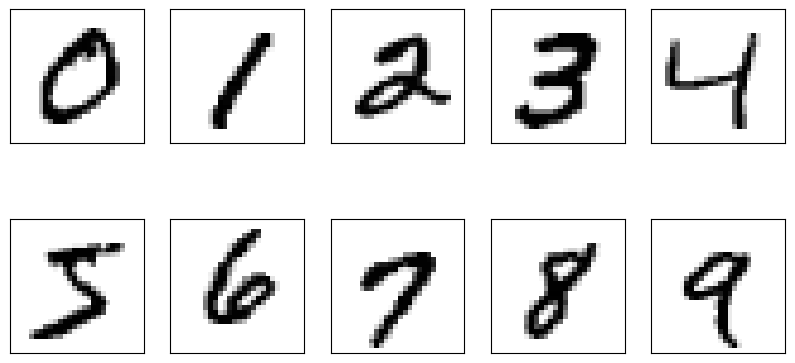

In [7]:
visualizationInstances(X_train, y_train)

# 2. Modelo neuronal para clasificación MNIST

Para el conjunto de datos MNIST, se implementarán varios modelos neuronales con el objetivo de analizar y estimar el sobreajuste. Cada uno de estos modelos será compilado y entrenado utilizando los datos previamente separados en conjuntos de entrenamiento y prueba.

En particular, utilizaremos un modelo de red neuronal completamente conectada como base. Este modelo se caracterizará por diferentes configuraciones en cuanto al número de capas ocultas y el número de neuronas en cada capa. Al variar estos parámetros, podremos ajustar la complejidad del modelo y observar cómo estos cambios afectan al rendimiento y al sobreajuste.

La idea es evaluar cómo un aumento en la complejidad del modelo—medido por el número de capas ocultas y neuronas—puede influir en la capacidad del modelo para generalizar a datos no vistos. Usaremos estos modelos para comparar el comportamiento del sobreajuste en función de la complejidad de la red y probar las técnicas de mitigación de sobreajuste.

## 2.1 Variación de la profundidad del modelo

In [8]:
def addLayer(dense_input, n):
    """
    Añade capas densas (fully connected) a una red neuronal de manera recursiva.

    Args:
    dense_input (Tensor): La entrada a la capa densa, que puede ser la salida de una capa anterior.
    n (int): El número de capas densas a añadir. Si n >= 2, se añaden capas adicionales recursivamente.

    Returns:
    Tensor: La salida de la última capa densa añadida.

    La función funciona de la siguiente manera:
    - Si n es mayor o igual a 2, se crea una nueva capa densa con 100 neuronas y activación ReLU, y se aplica recursivamente para añadir más capas.
    - Cuando n es igual a 1, se crea la última capa densa con 100 neuronas y activación ReLU, y se retorna como la salida final.
    """
    if n >= 2:
        # Añade una capa densa con 100 neuronas y función de activación ReLU.
        resDense = Dense(100, activation='relu')(dense_input)
        # Llama a la función recursivamente para añadir más capas.
        return addLayer(resDense, n-1)
    # Añade la última capa densa cuando n es 1.
    resDenseOut = Dense(100, activation='relu')(dense_input)
    return resDenseOut

In [9]:
def make_model(n):
    """
    Crea un modelo de red neuronal completamente conectada (MLP) con un número variable de capas densas ocultas.

    Args:
    n (int): El número de capas densas ocultas a añadir al modelo.

    Returns:
    keras.Model: Un modelo de Keras que incluye una capa de entrada, capas densas ocultas y una capa de salida.

    El modelo se construye de la siguiente manera:
    - Se limpia cualquier sesión anterior de Keras para evitar conflictos de estado.
    - Se define una capa de entrada con forma (28, 28) que representa imágenes en escala de grises de 28x28 píxeles.
    - La entrada se aplana utilizando una capa `Flatten` para convertir la imagen 2D en un vector 1D.
    - Se añade una primera capa densa con 100 neuronas y activación ReLU.
    - Se añaden capas densas ocultas adicionales utilizando la función `addLayer`, que toma el número `n` como argumento.
    - Finalmente, se añade una capa de salida con 10 neuronas y activación softmax para la clasificación de 10 dígitos.
    - El modelo se retorna con el nombre `modeloDenso{n}`, donde `{n}` es el número de capas ocultas.

    La función `addLayer` es utilizada para añadir el número deseado de capas densas ocultas, variando la complejidad del modelo según el valor de `n`.
    """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado
    inputs = Input(shape=[28, 28], name='InputLayer')  # Capa de entrada para imágenes de 28x28 píxeles
    flatten = Flatten(name='FlattenLayer')(inputs)  # Aplana la entrada para convertirla en un vector 1D
    firstLayer = Dense(100, activation='relu')(flatten)  # Primera capa densa con 100 neuronas y activación ReLU
    lastLayer = addLayer(firstLayer, n)  # Añade capas densas ocultas adicionales usando la función addLayer
    outputs = Dense(10, activation='softmax', name='OutputLayer')(lastLayer)  # Capa de salida para clasificación en 10 clases
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloDenso{n}')  # Retorna el modelo con el nombre especificado

In [10]:
# Llamado a la función de construir el modelo con parámetro el número de capas ocultas
model = make_model(2)

In [11]:
# Resumen de las dimensiones y parámetros del modelo
model.summary()

Model: "modeloDenso2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

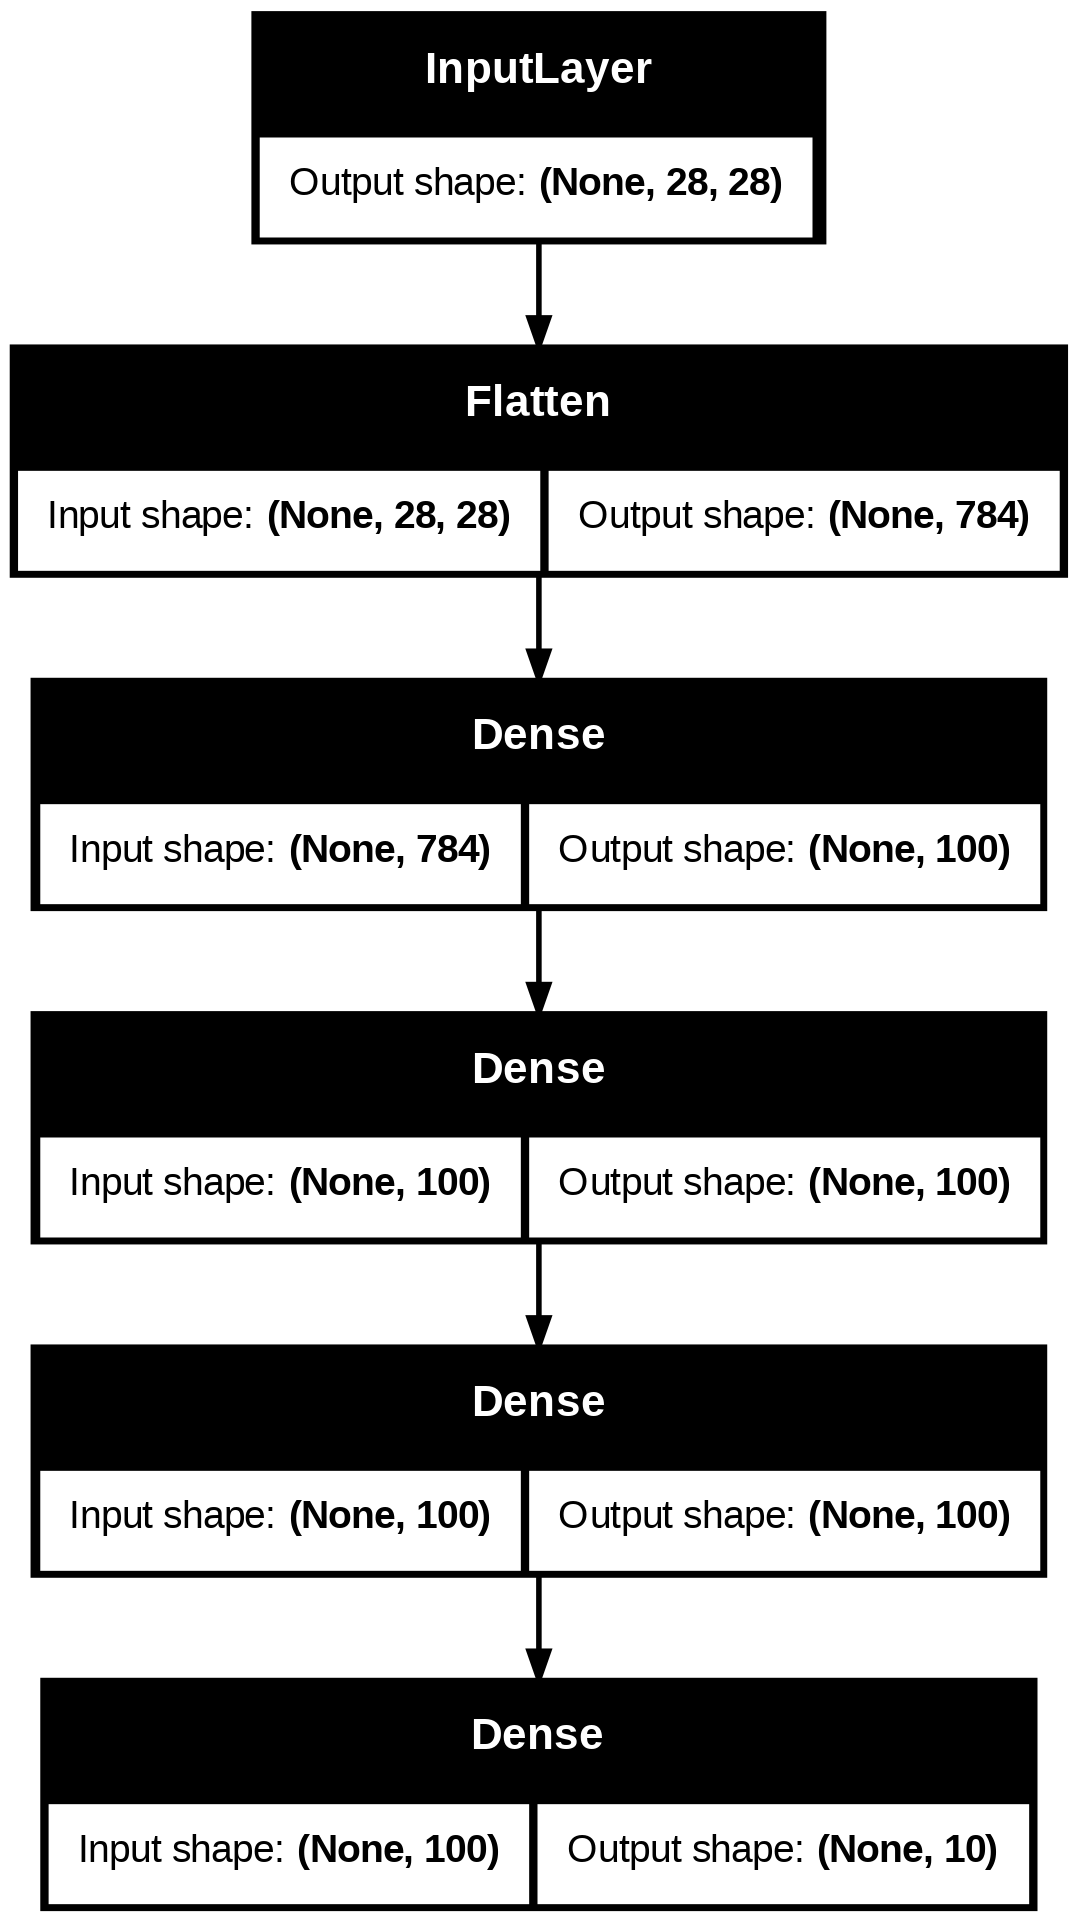

In [ ]:
# Para visualizar el modelo usando plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

Una vez que hemos definido la arquitectura de nuestro modelo, el siguiente paso es la compilación y el entrenamiento. En este laboratorio, nuestro objetivo es analizar cómo la variación en el número de capas ocultas afecta al rendimiento del modelo y al problema del sobreajuste. Para ello, entrenaremos modelos con diferentes configuraciones, específicamente con 1, 4, 8, 12, 16 y 20 capas ocultas. Esta variedad nos permitirá observar cómo el incremento en la complejidad de la red impacta en la capacidad del modelo para generalizar y en la incidencia del sobreajuste en los datos de prueba.

In [12]:
#  Lista que define el número de capas ocultas a utilizar en los modelos de red neuronal.
number_layers = [1, 4, 8, 12, 16, 20]

# Diccionario para guardar resultados
learning_curves = {}

In [13]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_layer in number_layers:
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model(number_layer)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

Model 1 layers done: acc_train 1.00, acc_val 0.87
Model 4 layers done: acc_train 1.00, acc_val 0.86
Model 8 layers done: acc_train 1.00, acc_val 0.85
Model 12 layers done: acc_train 1.00, acc_val 0.82
Model 16 layers done: acc_train 1.00, acc_val 0.83
Model 20 layers done: acc_train 0.98, acc_val 0.79


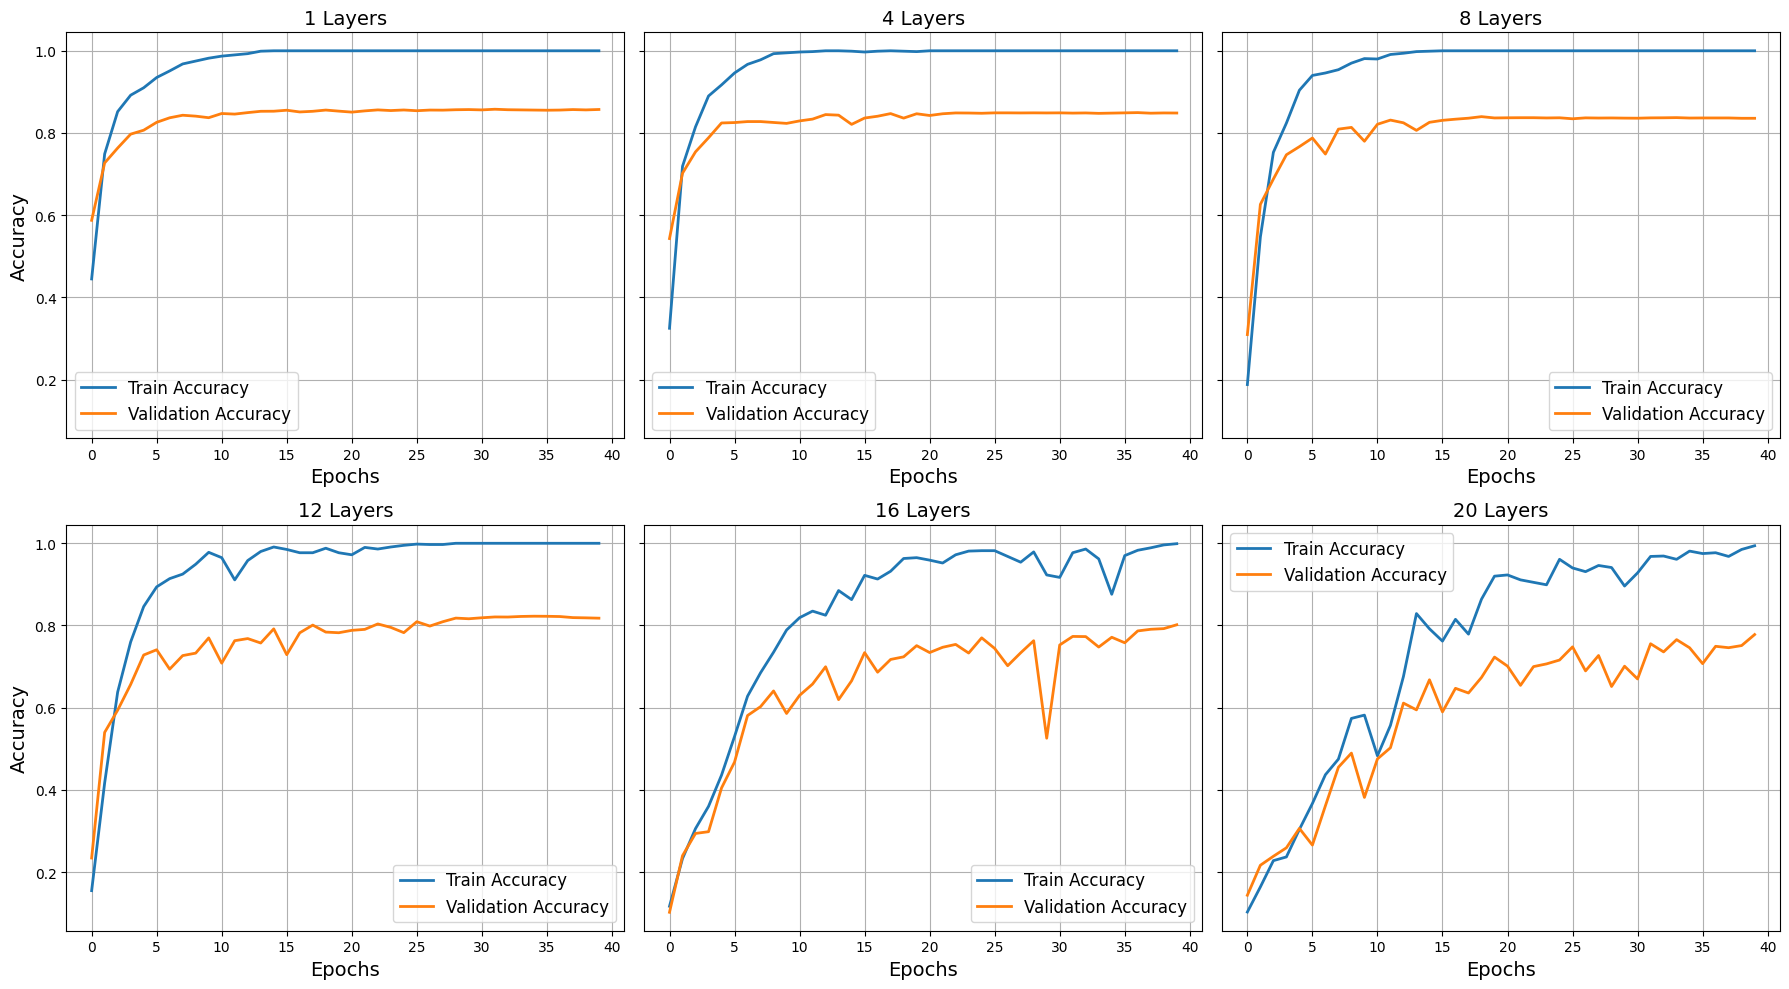

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

## 2.2 Variación del número de neuronas del modelo

In [ ]:
def make_model_neurons(neurons):
    """
    Crea un modelo de red neuronal con un número fijo de capas ocultas (5 capas),
    pero con un número variable de neuronas en cada capa según el parámetro `neurons_per_layer`.

    Args:
    neurons (int): número de neuronas para cada una de las 5 capas ocultas.

    Returns:
    keras.Model: Un modelo de Keras con 4 capas ocultas, cada una con el número de neuronas especificado.

     """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado

    # Crea la capa de entrada para imágenes de 28x28 píxeles.
    inputs = Input(shape=[28, 28], name='InputLayer')

    # Aplana la entrada para convertirla en un vector 1D.
    flatten = Flatten(name='FlattenLayer')(inputs)

    # Añade las capas ocultas con el número de neuronas especificado en `neurons_per_layer`.
    x = flatten
    for _ in range(5):
        x = Dense(neurons, activation='relu')(x)

    # Añade la capa de salida con 10 neuronas y activación softmax para clasificación.
    outputs = Dense(10, activation='softmax', name='OutputLayer')(x)

    # Retorna el modelo con el nombre especificado.
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloNeuronaVariable')

In [ ]:
# Llamado a la función de construir el modelo con parámetro el número de capas ocultas
model = make_model_neurons(20)

In [ ]:
# Resumen de las dimensiones y parámetros del modelo
model.summary()

Model: "modeloNeuronaVariable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FlattenLayer (Flatten)               │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          15,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,590 (68.71 KB)

 Trainable params: 17,590 (68.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Lista que define el número de capas ocultas a utilizar en los modelos de red neuronal.
number_neurons = [10, 50, 100, 200, 500, 1000]

# Diccionario para guardar resultados
learning_curves = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_neuron in number_neurons:
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model_neurons(number_neuron)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_neuron} neurons done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_neuron] = results

Model 10 neurons done: acc_train 0.93, acc_val 0.71
Model 50 neurons done: acc_train 1.00, acc_val 0.84
Model 100 neurons done: acc_train 1.00, acc_val 0.85
Model 200 neurons done: acc_train 1.00, acc_val 0.88
Model 500 neurons done: acc_train 1.00, acc_val 0.87
Model 1000 neurons done: acc_train 1.00, acc_val 0.87


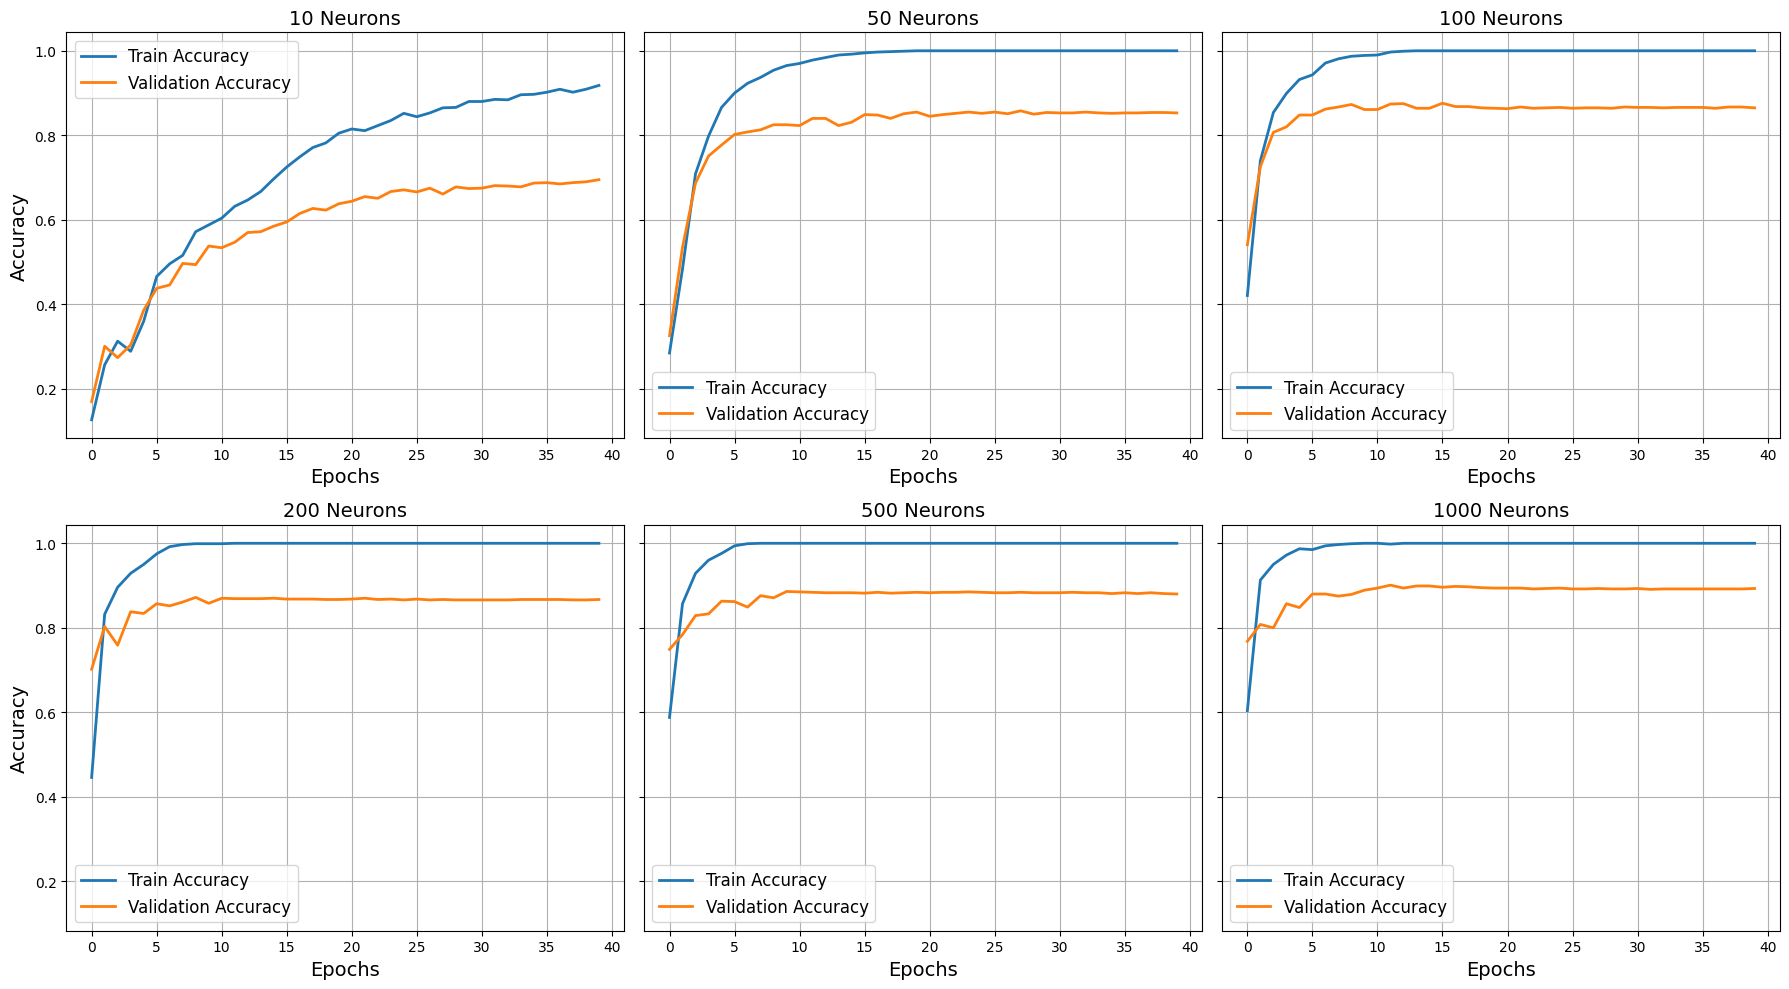

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, neurons in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[neurons].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[neurons].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{neurons} Neurons', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

# 3. Técnicas de validación cruzada

En esta sección se evaluará cómo detectar el sobreajuste en modelos neuronales mediante el uso de métodos de validación cruzada. Se probarán tres enfoques principales:

- **K-Fold Cross-Validation**: Esta técnica divide el conjunto de datos en k pliegues o particiones de igual tamaño. El modelo se entrena k veces, cada vez utilizando un pliegue diferente como conjunto de validación y los k-1 pliegues restantes como conjunto de entrenamiento. Este método proporciona una evaluación robusta del rendimiento del modelo al promediar los resultados obtenidos en cada iteración. Permite estimar cómo se comportará el modelo en datos no vistos y ayuda a identificar problemas de sobreajuste al comparar el rendimiento en diferentes pliegues.

- **Stratified K-Fold Cross-Validation**: Similar al K-Fold Cross-Validation, pero con la adición de que mantiene la proporción de clases en cada pliegue similar a la del conjunto de datos completo. Esto es especialmente útil en problemas de clasificación desequilibrada, donde algunas clases pueden ser menos frecuentes. Al asegurar que cada pliegue tenga una representación adecuada de todas las clases, el Stratified K-Fold proporciona una evaluación más precisa del rendimiento del modelo y ayuda a detectar el sobreajuste en contextos de distribución de clases desbalanceada.

- **Monte Carlo Cross-Validation**: También conocido como validación cruzada de muestreo aleatorio, este método implica crear múltiples particiones aleatorias del conjunto de datos en subconjuntos de entrenamiento y validación. En cada iteración, se entrena el modelo en una partición aleatoria y se evalúa en la partición complementaria. A diferencia del K-Fold, donde el número de pliegues es fijo, el Monte Carlo permite múltiples particiones aleatorias, proporcionando una evaluación más dinámica del rendimiento del modelo. Este enfoque ayuda a evaluar la estabilidad del modelo y su capacidad de generalización en diferentes configuraciones de datos.

## 3.1 K-Fold Cross Validation

In [ ]:
# Importa la clase KFold desde el módulo de selección de modelos de scikit-learn.
from sklearn.model_selection import KFold

# Crea una instancia de KFold con 5 pliegues, habilitando el barajado de datos y estableciendo una semilla aleatoria para la reproducibilidad.
# Esto asegura que los pliegues generados sean consistentes en ejecuciones posteriores.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Inicializa un diccionario vacío para almacenar los resultados de la validación cruzada K-Fold.
kfold_results = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_layer in number_layers:
    # Inicializa una lista para almacenar las precisiones obtenidas en cada pliegue del K-Fold.
    kfold_acc = []

    # Imprime el número de capas del modelo que se está evaluando.
    print(f'Model {number_layer} layers')

    # Inicializa un contador para rastrear el número de pliegues completados.
    i = 0

    # Itera sobre los pares de índices de entrenamiento y prueba generados por KFold.
    for train, test in kfold.split(X_train, y_train_onehot):
        # Crea un modelo neuronal con el número actual de capas ocultas.
        model = make_model(number_layer)

        # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entrena el modelo en el conjunto de entrenamiento del pliegue actual durante 40 épocas.
        model.fit(X_train[train], y_train_onehot[train], epochs=40, batch_size=32, verbose=0)

        # Evalúa el modelo en el conjunto de prueba del pliegue actual y obtiene la precisión.
        scores = model.evaluate(X_train[test], y_train_onehot[test], verbose=0)

        # Añade la precisión obtenida en este pliegue a la lista `kfold_acc`.
        kfold_acc.append(scores[1])

        # Incrementa el contador de pliegues completados.
        i += 1

        # Imprime el progreso de los pliegues completados.
        print(f'K-fold {i} done')

    # Imprime la precisión media y la desviación estándar de las precisiones obtenidas en todos los pliegues para el modelo actual.
    print(f'Model {number_layer} layers, mean_accuracy {np.mean(kfold_acc)}, std_accuracy {np.std(kfold_acc)}')
    print('\n')

    # Almacena la precisión media y la desviación estándar en el diccionario `kfold_results` para el modelo actual.
    kfold_results[number_layer] = {'mean_accuracy': np.mean(kfold_acc), 'std_accuracy': np.std(kfold_acc)}

# Imprime todos los resultados de la validación cruzada K-Fold para cada número de capas.
print("K-Fold Results:", kfold_results)

Model 1 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 1 layers, mean_accuracy 0.899999988079071, std_accuracy 0.025298218359809617


Model 4 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 4 layers, mean_accuracy 0.8929999947547913, std_accuracy 0.03957271989916409


Model 8 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 8 layers, mean_accuracy 0.8830000042915345, std_accuracy 0.029765742568542423


Model 12 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 12 layers, mean_accuracy 0.8689999938011169, std_accuracy 0.036523973639324074


Model 16 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 16 layers, mean_accuracy 0.8400000095367431, std_accuracy 0.021447617926302644


Model 20 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 20 layers, mean_accuracy 0.7230000019073486, std_ac

## 3.2 Stratified K-Fold Cross Validation

In [ ]:
# Importa la clase StratifiedKFold desde el módulo de selección de modelos de scikit-learn.
from sklearn.model_selection import StratifiedKFold

# Crea una instancia de StratifiedKFold con 5 pliegues, habilitando el barajado de datos y estableciendo una semilla aleatoria para la reproducibilidad.
# Este enfoque asegura que cada pliegue mantenga la proporción de clases similar a la del conjunto de datos completo.
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializa un diccionario vacío para almacenar los resultados de la validación cruzada StratifiedKFold.
stratified_kfold_results = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_layer in number_layers:
    # Inicializa una lista para almacenar las precisiones obtenidas en cada pliegue del StratifiedKFold.
    kfold_acc = []

    # Imprime el número de capas del modelo que se está evaluando.
    print(f'Model {number_layer} layers')

    # Inicializa un contador para rastrear el número de pliegues completados.
    i = 0

    # Itera sobre los pares de índices de entrenamiento y prueba generados por StratifiedKFold.
    for train, test in stratified_kfold.split(X_train, y_train):
        # Crea un modelo neuronal con el número actual de capas ocultas.
        model = make_model(number_layer)

        # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entrena el modelo en el conjunto de entrenamiento del pliegue actual durante 40 épocas.
        # Se utiliza `to_categorical` para convertir las etiquetas a una codificación one-hot.
        model.fit(X_train[train], to_categorical(y_train[train]), epochs=40, batch_size=32, verbose=0)

        # Evalúa el modelo en el conjunto de prueba del pliegue actual y obtiene la precisión.
        scores = model.evaluate(X_train[test], to_categorical(y_train[test]), verbose=0)

        # Añade la precisión obtenida en este pliegue a la lista `kfold_acc`.
        kfold_acc.append(scores[1])

        # Incrementa el contador de pliegues completados.
        i += 1

        # Imprime el progreso de los pliegues completados.
        print(f'K-fold {i} done')

    # Imprime la precisión media y la desviación estándar de las precisiones obtenidas en todos los pliegues para el modelo actual.
    print(f'Model {number_layer} layers, mean_accuracy {np.mean(kfold_acc)}, std_accuracy {np.std(kfold_acc)}')
    print('\n')

    # Almacena la precisión media y la desviación estándar en el diccionario `stratified_kfold_results` para el modelo actual.
    stratified_kfold_results[number_layer] = {'mean_accuracy': np.mean(kfold_acc), 'std_accuracy': np.std(kfold_acc)}

# Imprime todos los resultados de la validación cruzada StratifiedKFold para cada número de capas.
print("Stratified K-Fold Results:", stratified_kfold_results)

Model 1 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 1 layers, mean_accuracy 0.8919999837875366, std_accuracy 0.009273609651483924


Model 4 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 4 layers, mean_accuracy 0.8899999976158142, std_accuracy 0.012649117426193662


Model 8 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 8 layers, mean_accuracy 0.8899999856948853, std_accuracy 0.010488078479480903


Model 12 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 12 layers, mean_accuracy 0.8569999933242798, std_accuracy 0.025019996256383674


Model 16 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 16 layers, mean_accuracy 0.8639999985694885, std_accuracy 0.022449943619726256


Model 20 layers
K-fold 1 done
K-fold 2 done
K-fold 3 done
K-fold 4 done
K-fold 5 done
Model 20 layers, mean_accuracy 0.7950000047683716, std_

## 3.3 Monte Carlo Cross Validation

In [ ]:
# Importa la clase ShuffleSplit desde el módulo de selección de modelos de scikit-learn.
from sklearn.model_selection import ShuffleSplit

# Crea una instancia de ShuffleSplit con 5 divisiones, un tamaño de prueba del 20% y estableciendo una semilla aleatoria para la reproducibilidad.
# Esto realiza múltiples particiones aleatorias de los datos en entrenamiento y prueba, con cada partición manteniendo el 20% de los datos como conjunto de prueba.
monte_carlo = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Inicializa un diccionario vacío para almacenar los resultados de la validación Monte Carlo.
monte_carlo_results = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_layer in number_layers:
    # Inicializa una lista para almacenar las precisiones obtenidas en cada partición de Monte Carlo.
    monte_carlo_acc = []

    # Imprime el número de capas del modelo que se está evaluando.
    print(f'Model {number_layer} layers')

    # Inicializa un contador para rastrear el número de iteraciones completadas.
    i = 0

    # Itera sobre los pares de índices de entrenamiento y prueba generados por ShuffleSplit.
    for train, test in monte_carlo.split(X_train, y_train):
        # Crea un modelo neuronal con el número actual de capas ocultas.
        model = make_model(number_layer)

        # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entrena el modelo en el conjunto de entrenamiento del pliegue actual durante 40 épocas.
        # Se utiliza `to_categorical` para convertir las etiquetas a una codificación one-hot.
        model.fit(X_train[train], to_categorical(y_train[train]), epochs=40, batch_size=32, verbose=0)

        # Evalúa el modelo en el conjunto de prueba del pliegue actual y obtiene la precisión.
        scores = model.evaluate(X_train[test], to_categorical(y_train[test]), verbose=0)

        # Añade la precisión obtenida en esta iteración a la lista `monte_carlo_acc`.
        monte_carlo_acc.append(scores[1])

        # Incrementa el contador de iteraciones completadas.
        i += 1

        # Imprime el progreso de las iteraciones completadas.
        print(f'Iteration {i} done')

    # Imprime la precisión media y la desviación estándar de las precisiones obtenidas en todas las iteraciones para el modelo actual.
    print(f'Model {number_layer} layers, mean_accuracy {np.mean(monte_carlo_acc)}, std_accuracy {np.std(monte_carlo_acc)}')
    print('\n')

    # Almacena la precisión media y la desviación estándar en el diccionario `monte_carlo_results` para el modelo actual.
    monte_carlo_results[number_layer] = {'mean_accuracy': np.mean(monte_carlo_acc), 'std_accuracy': np.std(monte_carlo_acc)}

# Imprime todos los resultados de la validación Monte Carlo para cada número de capas.
print("Monte Carlo Results:", monte_carlo_results)

Model 1 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Model 1 layers, mean_accuracy 0.9069999933242798, std_accuracy 0.016911543773572832


Model 4 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Model 4 layers, mean_accuracy 0.897000002861023, std_accuracy 0.021587037960341653


Model 8 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Model 8 layers, mean_accuracy 0.8919999957084656, std_accuracy 0.019131125672126208


Model 12 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Model 12 layers, mean_accuracy 0.8740000009536744, std_accuracy 0.021540638685764554


Model 16 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
Iteration 5 done
Model 16 layers, mean_accuracy 0.8670000195503235, std_accuracy 0.02379075336429407


Model 20 layers
Iteration 1 done
Iteration 2 done
Iteration 3 done
I

---------------------

# 4. Técnicas para mitigar el sobreajuste


En esta sesión, exploraremos diversas técnicas para mitigar el sobreajuste en modelos de redes neuronales. Las técnicas que se abordarán incluyen:

1. **Regularización L2**
La regularización L2 agrega una penalización a los pesos del modelo durante el entrenamiento. Este método ayuda a evitar que los pesos se vuelvan excesivamente grandes, lo cual puede conducir al sobreajuste. La regularización L2 se aplica mediante el parámetro `kernel_regularizer=l2(regularization_factor)` en las capas densas.

2. **Regularización L1**
La regularización L1 añade una penalización basada en la magnitud absoluta de los pesos. A diferencia de L2, L1 puede llevar a que algunos pesos se reduzcan exactamente a cero, promoviendo un modelo más escaso y potencialmente más generalizable. Se puede aplicar usando el parámetro `kernel_regularizer=l1(regularization_factor`).

3. **Dropout**
Dropout es una técnica que consiste en desactivar aleatoriamente una fracción de las neuronas durante el entrenamiento, lo que ayuda a prevenir el sobreajuste. Se puede aplicar en el modelo utilizando `Dropout(rate)` donde rate es la fracción de neuronas que se desactivarán en cada paso.

4. **Parada Temprana**
La parada temprana es una técnica que detiene el entrenamiento cuando el desempeño en el conjunto de validación deja de mejorar, evitando así el sobreajuste. Se configura mediante el callback `EarlyStopping` y permite especificar la paciencia (número de épocas sin mejora antes de detener el entrenamiento) y la métrica a monitorear.

5. **Regularización Generalizada** (Combina parada temprana y Dropout)
Una combinación de regularización por parada temprana y Dropout puede ofrecer beneficios adicionales. Mezclando ambos efectos en la construcción y entrenamiento del modelo.

## 4.1 Regularización L2

La **regularización L2**, es una técnica que agrega una penalización a los pesos del modelo durante el proceso de entrenamiento, lo que ayuda a evitar que los pesos se vuelvan excesivamente grandes.

La función de pérdida con regularización L2 se define como:

$$ L_{\text{total}} = L_{\text{original}} + \frac{\lambda}{2} \sum_{i=1}^{n} w_i^2 $$

donde:

- $L_{\text{total}}$ es la función de pérdida total, que incluye la penalización.
- $L_{\text{original}} $ es la función de pérdida original (por ejemplo, entropía cruzada).
- $\lambda $ es el parámetro de regularización (también conocido como *factor de regularización*), que controla la magnitud de la penalización.
- $ w_i$ son los pesos del modelo.
- $ n $ es el número de pesos en el modelo.

In [ ]:
# En Keras, la regularización L2 se puede aplicar a las capas densas utilizando el parámetro `kernel_regularizer` con la función `l2` del módulo `keras.regularizers`.
# Importa la función de regularización L2 del módulo `regularizers` de Keras.
from keras.regularizers import l2

In [ ]:
def addLayer_l2(dense_input, n, regularization_factor):
    """
    Añade capas densas (fully connected) a una red neuronal de manera recursiva,
    con un factor de regularización L2.

    Args:
    dense_input (Tensor): La entrada a la capa densa, que puede ser la salida de una capa anterior.
    n (int): El número de capas densas a añadir. Si n >= 2, se añaden capas adicionales recursivamente.
    regularization_factor (float): El factor de regularización L2 para las capas densas.

    Returns:
    Tensor: La salida de la última capa densa añadida.

    La función funciona de la siguiente manera:
    - Si n es mayor o igual a 2, se crea una nueva capa densa con 100 neuronas, función de activación ReLU,
      y se aplica recursivamente para añadir más capas.
    - Cuando n es igual a 1, se crea la última capa densa con 100 neuronas, función de activación ReLU,
      y se retorna como la salida final.
    """
    if n >= 2:
        # Añade una capa densa con 100 neuronas, función de activación ReLU y regularización L2.
        resDense = Dense(100, activation='relu', kernel_regularizer=l2(regularization_factor))(dense_input)
        # Llama a la función recursivamente para añadir más capas.
        return addLayer(resDense, n-1, regularization_factor)
    # Añade la última capa densa cuando n es 1 con regularización L2.
    resDenseOut = Dense(100, activation='relu', kernel_regularizer=l2(regularization_factor))(dense_input)
    return resDenseOut

In [ ]:
def make_model_l2(n, regularization_factor=0.001):
    """
    Crea un modelo de red neuronal completamente conectada (MLP) con un número variable de capas densas ocultas,
    e incluye un factor de regularización en las capas densas ocultas.

    Args:
    n (int): El número de capas densas ocultas a añadir al modelo.
    regularization_factor (float): El factor de regularización para las capas densas ocultas (por defecto es 0.01).

    Returns:
    keras.Model: Un modelo de Keras que incluye una capa de entrada, capas densas ocultas y una capa de salida.

    El modelo se construye de la siguiente manera:
    - Se limpia cualquier sesión anterior de Keras para evitar conflictos de estado.
    - Se define una capa de entrada con forma (28, 28) que representa imágenes en escala de grises de 28x28 píxeles.
    - La entrada se aplana utilizando una capa `Flatten` para convertir la imagen 2D en un vector 1D.
    - Se añade una primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L2.
    - Se añaden capas densas ocultas adicionales utilizando la función `addLayer`, que toma el número `n` y el factor de regularización como argumentos.
    - Finalmente, se añade una capa de salida con 10 neuronas y activación softmax para la clasificación de 10 dígitos.
    - El modelo se retorna con el nombre `modeloDenso{n}`, donde `{n}` es el número de capas ocultas.

    La función `addLayer` es utilizada para añadir el número deseado de capas densas ocultas, variando la complejidad del modelo según el valor de `n`.
    """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado
    inputs = Input(shape=[28, 28], name='InputLayer')  # Capa de entrada para imágenes de 28x28 píxeles
    flatten = Flatten(name='FlattenLayer')(inputs)  # Aplana la entrada para convertirla en un vector 1D
    # Primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L2
    firstLayer = Dense(100, activation='relu', kernel_regularizer=l2(regularization_factor))(flatten)
    # Añade capas densas ocultas adicionales usando la función addLayer con regularización
    lastLayer = addLayer_l2(firstLayer, n, regularization_factor)
    outputs = Dense(10, activation='softmax', name='OutputLayer')(lastLayer)  # Capa de salida para clasificación en 10 clases
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloDenso{n}')  # Retorna el modelo con el nombre especificado

In [ ]:
regularization_factors = [0.2, 0.05, 0.01, 0.001, 0.0005, 0.00005]
learning_curves = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for rl, number_layer in zip(regularization_factors, number_layers):
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model_l2(number_layer, rl)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

Model 1 layers done: acc_train 0.82, acc_val 0.72
Model 4 layers done: acc_train 0.77, acc_val 0.67
Model 8 layers done: acc_train 0.95, acc_val 0.70
Model 12 layers done: acc_train 1.00, acc_val 0.79
Model 16 layers done: acc_train 0.99, acc_val 0.74
Model 20 layers done: acc_train 0.12, acc_val 0.10


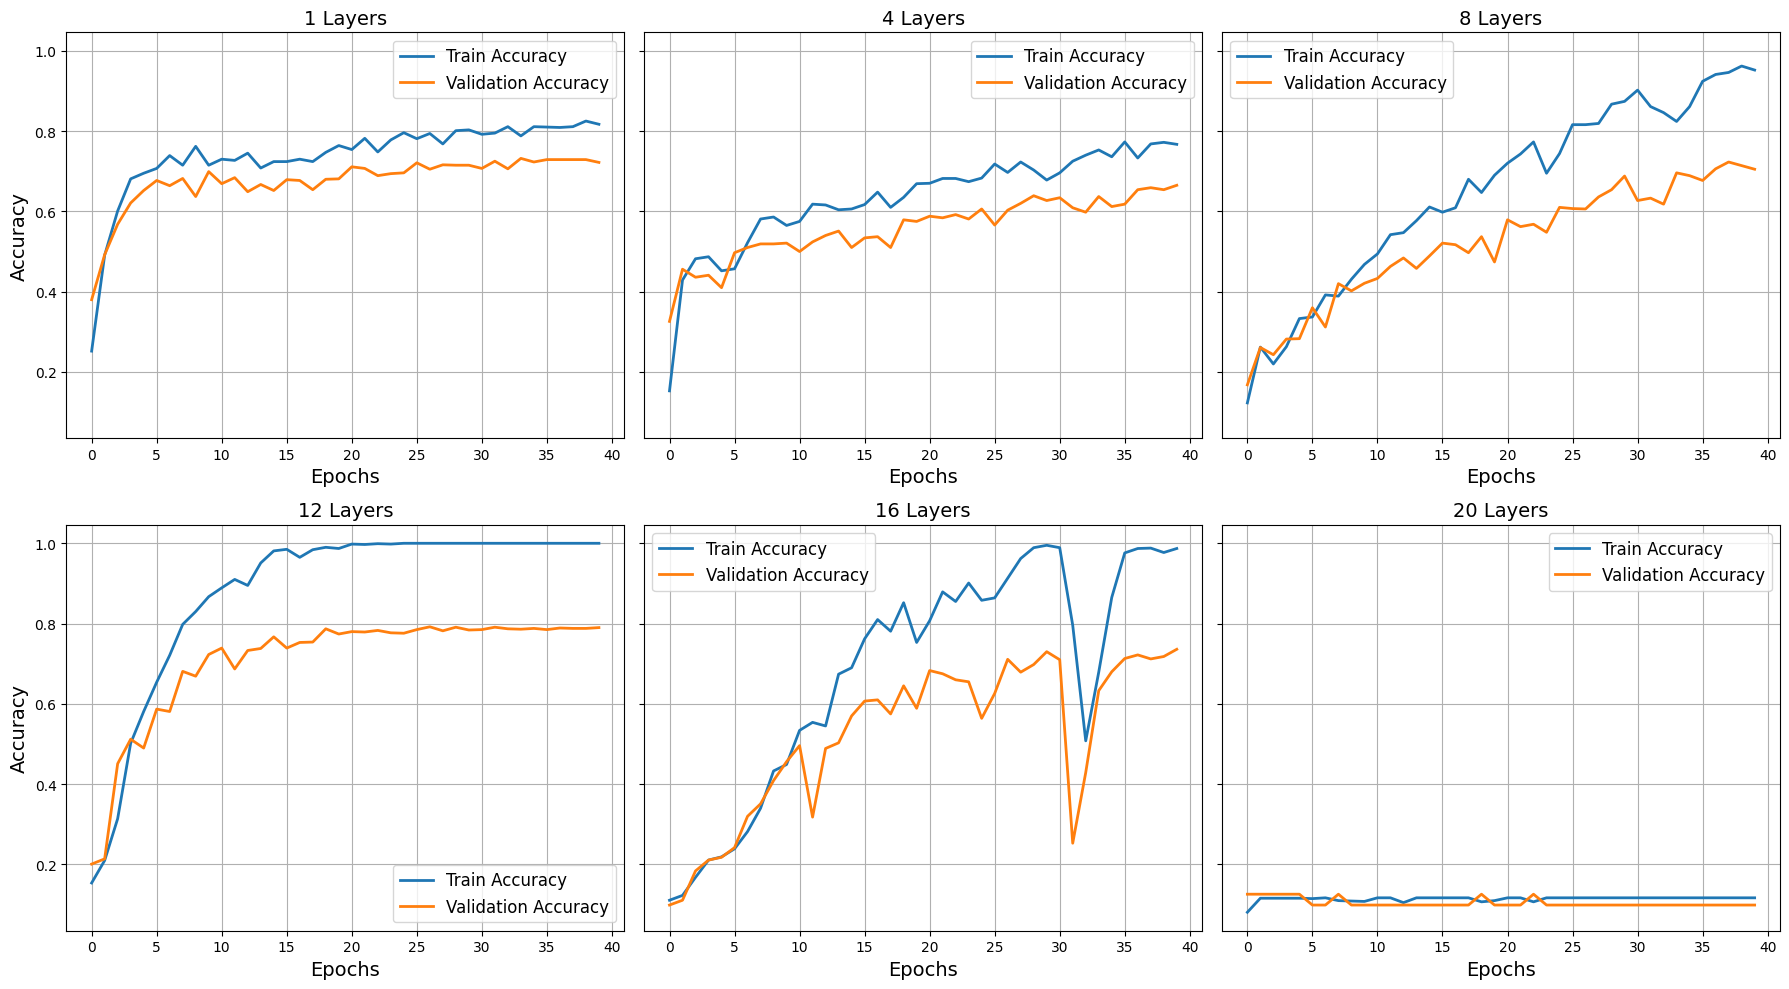

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

**Actividad**: El rendimiento mostrado en las curvas de aprendizaje actuales no es óptimo. Su tarea es ajustar los factores de regularización para mejorar el desempeño de nuestros modelos neuronales y reducir el sobreajuste.


**Preguntas**


1. ¿Qué tan difícil es encontrar el parámetro adecuado? ¿Es un proceso fácil o requiere un análisis profundo?
¿De qué depende este factor?

2. Considere los factores que influyen en la elección del valor de regularización. ¿Cómo afecta la complejidad del modelo, la cantidad de datos, o la arquitectura general a la selección del factor de regularización?

**Resultado Esperado**
Encuentre el factor de regularización que mejor reduzca el sobreajuste y ofrezca el mejor desempeño general en el modelo. Este será el factor que minimice la diferencia entre las precisiones de entrenamiento y validación, logrando una mejor generalización a nuevos datos.

In [ ]:
# Tu código comienza aqui !!

## 4.2 Regularización L1

La regularización L1 agrega un término de penalización a la función de pérdida del modelo que es proporcional a la suma de los valores absolutos de los pesos de la red.


La función de pérdida regularizada con L1 se define como:

$$ L_{total} = L_{original} + \lambda \sum_{i} |w_i| $$

Donde:
- $ L_{total} $ es la función de pérdida total, que incluye el término de regularización.
- $ L_{original} $ es la función de pérdida original sin regularización.
- $ \lambda $ es el factor de regularización L1, que controla la fuerza de la penalización.
- $ w_i $ son los pesos de la red neuronal.

In [ ]:
# En Keras, la regularización L1 se puede aplicar a las capas densas utilizando el parámetro `kernel_regularizer` con la función `l1` del módulo `keras.regularizers`.
# Importa la función de regularización L1 del módulo `regularizers` de Keras.
from keras.regularizers import l1

In [ ]:
def addLayer_l1(dense_input, n, regularization_factor):
    """
    Añade capas densas (fully connected) a una red neuronal de manera recursiva,
    con un factor de regularización L2.

    Args:
    dense_input (Tensor): La entrada a la capa densa, que puede ser la salida de una capa anterior.
    n (int): El número de capas densas a añadir. Si n >= 2, se añaden capas adicionales recursivamente.
    regularization_factor (float): El factor de regularización L1 para las capas densas.

    Returns:
    Tensor: La salida de la última capa densa añadida.

    La función funciona de la siguiente manera:
    - Si n es mayor o igual a 2, se crea una nueva capa densa con 100 neuronas, función de activación ReLU,
      y se aplica recursivamente para añadir más capas.
    - Cuando n es igual a 1, se crea la última capa densa con 100 neuronas, función de activación ReLU,
      y se retorna como la salida final.
    """
    if n >= 2:
        # Añade una capa densa con 100 neuronas, función de activación ReLU y regularización L1.
        resDense = Dense(100, activation='relu', kernel_regularizer=l1(regularization_factor))(dense_input)
        # Llama a la función recursivamente para añadir más capas.
        return addLayer(resDense, n-1, regularization_factor)
    # Añade la última capa densa cuando n es 1 con regularización L1.
    resDenseOut = Dense(100, activation='relu', kernel_regularizer=l1(regularization_factor))(dense_input)
    return resDenseOut

In [ ]:
def make_model_l1(n, regularization_factor=0.001):
    """
    Crea un modelo de red neuronal completamente conectada (MLP) con un número variable de capas densas ocultas,
    e incluye un factor de regularización en las capas densas ocultas.

    Args:
    n (int): El número de capas densas ocultas a añadir al modelo.
    regularization_factor (float): El factor de regularización para las capas densas ocultas (por defecto es 0.01).

    Returns:
    keras.Model: Un modelo de Keras que incluye una capa de entrada, capas densas ocultas y una capa de salida.

    El modelo se construye de la siguiente manera:
    - Se limpia cualquier sesión anterior de Keras para evitar conflictos de estado.
    - Se define una capa de entrada con forma (28, 28) que representa imágenes en escala de grises de 28x28 píxeles.
    - La entrada se aplana utilizando una capa `Flatten` para convertir la imagen 2D en un vector 1D.
    - Se añade una primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L2.
    - Se añaden capas densas ocultas adicionales utilizando la función `addLayer`, que toma el número `n` y el factor de regularización como argumentos.
    - Finalmente, se añade una capa de salida con 10 neuronas y activación softmax para la clasificación de 10 dígitos.
    - El modelo se retorna con el nombre `modeloDenso{n}`, donde `{n}` es el número de capas ocultas.

    La función `addLayer` es utilizada para añadir el número deseado de capas densas ocultas, variando la complejidad del modelo según el valor de `n`.
    """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado
    inputs = Input(shape=[28, 28], name='InputLayer')  # Capa de entrada para imágenes de 28x28 píxeles
    flatten = Flatten(name='FlattenLayer')(inputs)  # Aplana la entrada para convertirla en un vector 1D
    # Primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L1
    firstLayer = Dense(100, activation='relu', kernel_regularizer=l1(regularization_factor))(flatten)
    # Añade capas densas ocultas adicionales usando la función addLayer con regularización
    lastLayer = addLayer_l1(firstLayer, n, regularization_factor)
    outputs = Dense(10, activation='softmax', name='OutputLayer')(lastLayer)  # Capa de salida para clasificación en 10 clases
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloDenso{n}')  # Retorna el modelo con el nombre especificado

In [ ]:
regularization_factors = [0.001, 0.001, 0.001, 0.001, 0.0005, 0.0000005]
learning_curves = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for rl, number_layer in zip(regularization_factors, number_layers):
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model_l1(number_layer, rl)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

Model 1 layers done: acc_train 0.98, acc_val 0.86
Model 4 layers done: acc_train 0.99, acc_val 0.83
Model 8 layers done: acc_train 0.82, acc_val 0.69
Model 12 layers done: acc_train 0.98, acc_val 0.71
Model 16 layers done: acc_train 0.12, acc_val 0.10
Model 20 layers done: acc_train 0.98, acc_val 0.71


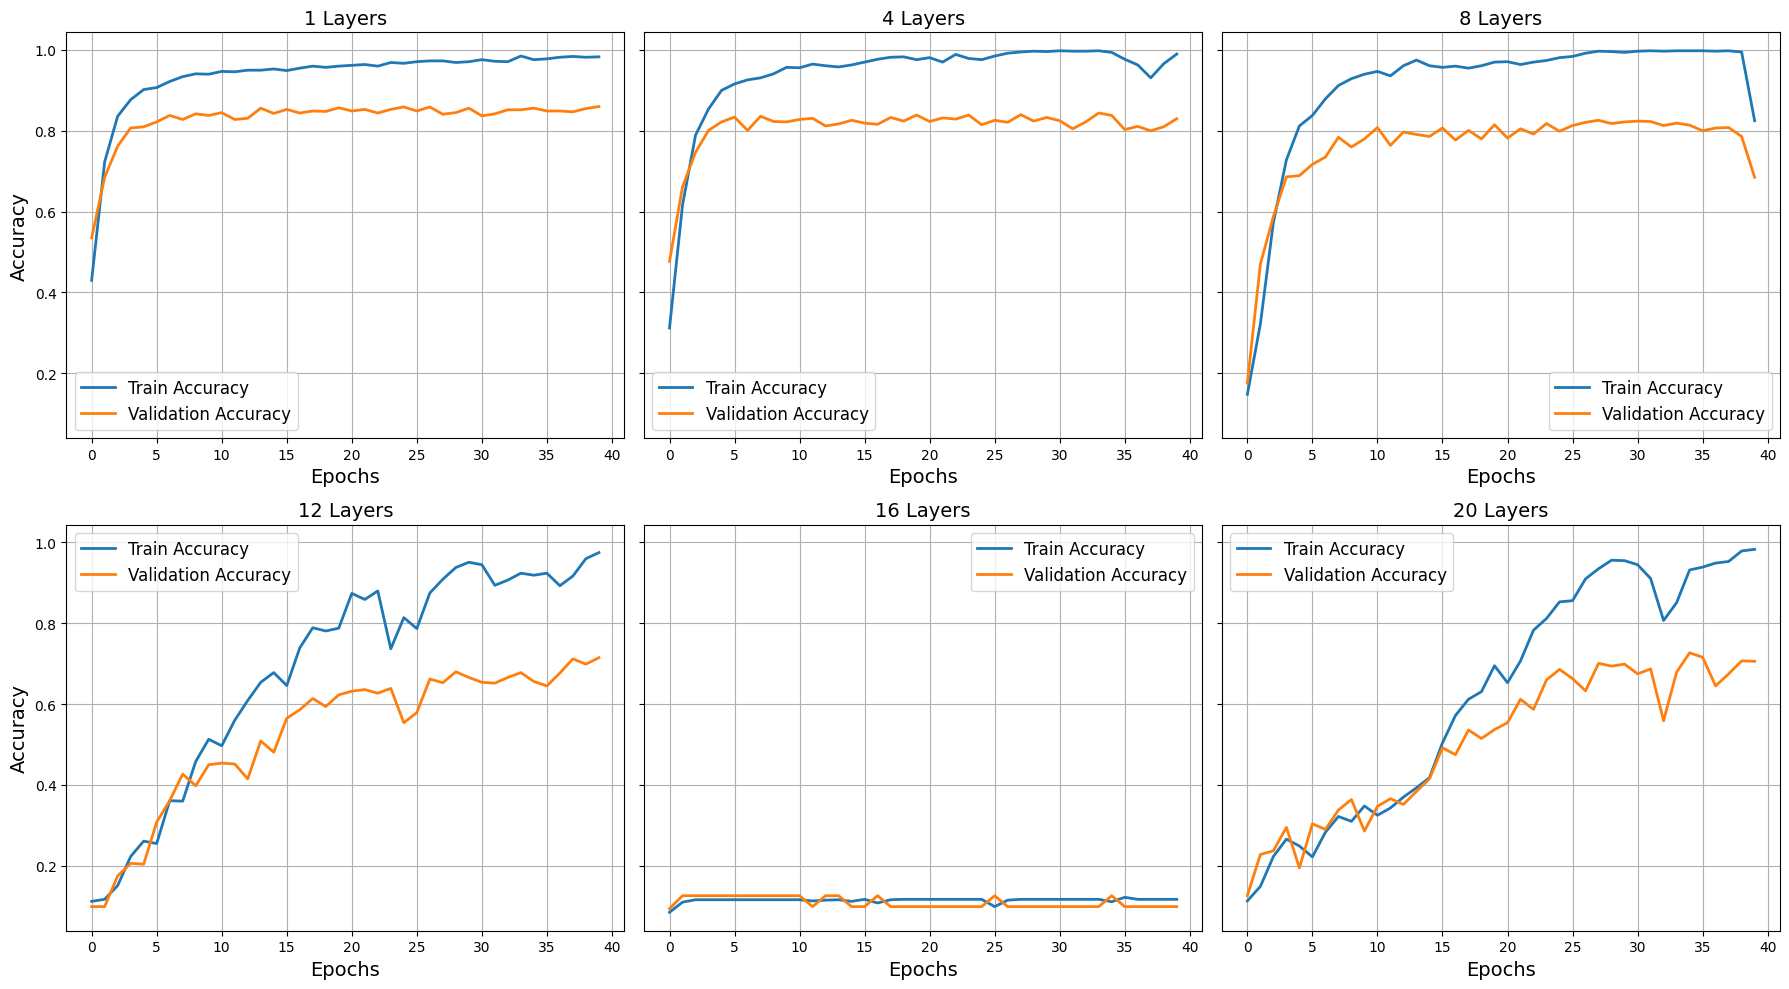

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

**Actividad**: El rendimiento mostrado en las curvas de aprendizaje actuales no es óptimo. Su tarea es ajustar los factores de regularización para mejorar el desempeño de nuestros modelos neuronales y reducir el sobreajuste.


**Preguntas para Reflexionar**


1. ¿Qué tan difícil es encontrar el parámetro adecuado? ¿Es un proceso fácil o requiere un análisis profundo?
¿De qué depende este factor?

2. Considere los factores que influyen en la elección del valor de regularización. ¿Cómo afecta la complejidad del modelo, la cantidad de datos, o la arquitectura general a la selección del factor de regularización?

**Resultado Esperado**
Encuentre el factor de regularización que mejor reduzca el sobreajuste y ofrezca el mejor desempeño general en el modelo. Este será el factor que minimice la diferencia entre las precisiones de entrenamiento y validación, logrando una mejor generalización a nuevos datos.

In [ ]:
# Tu código comienza aqui !!

## 4.3 Dropout

En esta técnica durante el entrenamiento,  aleatoriamente se "apaga" (es decir, pone en cero) un porcentaje de las neuronas en cada capa durante cada iteración de entrenamiento. Esto obliga a la red a aprender representaciones más robustas y generalizables, ya que el modelo no puede depender de neuronas específicas.

La función de pérdida del modelo con Dropout no cambia, pero el proceso de Dropout se aplica durante el entrenamiento de la siguiente manera:

- Para cada iteración de entrenamiento, se selecciona aleatoriamente un subconjunto de neuronas para que se "apaguen" con una probabilidad $ p $. La probabilidad $p$  se denomina tasa de Dropout.
- Las neuronas apagadas tienen un valor de salida de cero.



In [ ]:
# Para aplicar Dropout en Keras, se utiliza la capa `Dropout`
from tensorflow.keras.layers import Dropout

In [ ]:
def addLayer_dropout(dense_input, n, dropout_rate):
    """
    Añade capas densas (fully connected) a una red neuronal de manera recursiva,
    con capas de Dropout para prevenir el sobreajuste.

    Args:
    dense_input (Tensor): La entrada a la capa densa, que puede ser la salida de una capa anterior.
    n (int): El número de capas densas a añadir. Si n >= 2, se añaden capas adicionales recursivamente.
    dropout_rate (float): La tasa de dropout para las capas.

    Returns:
    Tensor: La salida de la última capa densa añadida.

    La función funciona de la siguiente manera:
    - Si n es mayor o igual a 2, se crea una nueva capa densa con 100 neuronas, función de activación ReLU,
      seguida de una capa de dropout. Luego se aplica recursivamente para añadir más capas.
    - Cuando n es igual a 1, se crea la última capa densa con 100 neuronas, función de activación ReLU,
      seguida de una capa de dropout, y se retorna como la salida final.
    """
    if n >= 2:
        # Añade una capa densa con 100 neuronas, función de activación ReLU.
        resDense = Dense(100, activation='relu')(dense_input)
        # Añade una capa de Dropout con la tasa especificada.
        resDense = Dropout(dropout_rate)(resDense)
        # Llama a la función recursivamente para añadir más capas.
        return addLayer_dropout(resDense, n-1, dropout_rate)
    # Añade la última capa densa cuando n es 1 con Dropout.
    resDenseOut = Dense(100, activation='relu')(dense_input)
    resDenseOut = Dropout(dropout_rate)(resDenseOut)
    return resDenseOut

In [ ]:
def make_model_dropout(n, dropout_rate=0.1):
    """
    Crea un modelo de red neuronal completamente conectada (MLP) con un número variable de capas densas ocultas,
    e incluye un factor de regularización en las capas densas ocultas.

    Args:
    n (int): El número de capas densas ocultas a añadir al modelo.
    regularization_factor (float): El factor de regularización para las capas densas ocultas (por defecto es 0.01).

    Returns:
    keras.Model: Un modelo de Keras que incluye una capa de entrada, capas densas ocultas y una capa de salida.

    El modelo se construye de la siguiente manera:
    - Se limpia cualquier sesión anterior de Keras para evitar conflictos de estado.
    - Se define una capa de entrada con forma (28, 28) que representa imágenes en escala de grises de 28x28 píxeles.
    - La entrada se aplana utilizando una capa `Flatten` para convertir la imagen 2D en un vector 1D.
    - Se añade una primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L2.
    - Se añaden capas densas ocultas adicionales utilizando la función `addLayer`, que toma el número `n` y el factor de regularización como argumentos.
    - Finalmente, se añade una capa de salida con 10 neuronas y activación softmax para la clasificación de 10 dígitos.
    - El modelo se retorna con el nombre `modeloDenso{n}`, donde `{n}` es el número de capas ocultas.

    La función `addLayer` es utilizada para añadir el número deseado de capas densas ocultas, variando la complejidad del modelo según el valor de `n`.
    """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado
    inputs = Input(shape=[28, 28], name='InputLayer')  # Capa de entrada para imágenes de 28x28 píxeles
    flatten = Flatten(name='FlattenLayer')(inputs)  # Aplana la entrada para convertirla en un vector 1D
    # Primera capa densa con 100 neuronas, activación ReLU y un factor de regularización L2
    firstLayer = Dense(100, activation='relu')(flatten)
    # Añade capas densas ocultas adicionales usando la función addLayer con regularización
    lastLayer = addLayer_dropout(firstLayer, n, dropout_rate)
    outputs = Dense(10, activation='softmax', name='OutputLayer')(lastLayer)  # Capa de salida para clasificación en 10 clases
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloDenso{n}')  # Retorna el modelo con el nombre especificado

In [ ]:
dropout_probabilities = [0.3, 0.3, 0.3, 0.3, 0.2, 0.2]
learning_curves = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for p, number_layer in zip(dropout_probabilities, number_layers):
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model_dropout(number_layer, p)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

Model 1 layers done: acc_train 1.00, acc_val 0.89
Model 4 layers done: acc_train 0.99, acc_val 0.88
Model 8 layers done: acc_train 0.94, acc_val 0.81
Model 12 layers done: acc_train 0.45, acc_val 0.40
Model 16 layers done: acc_train 0.66, acc_val 0.52
Model 20 layers done: acc_train 0.48, acc_val 0.31


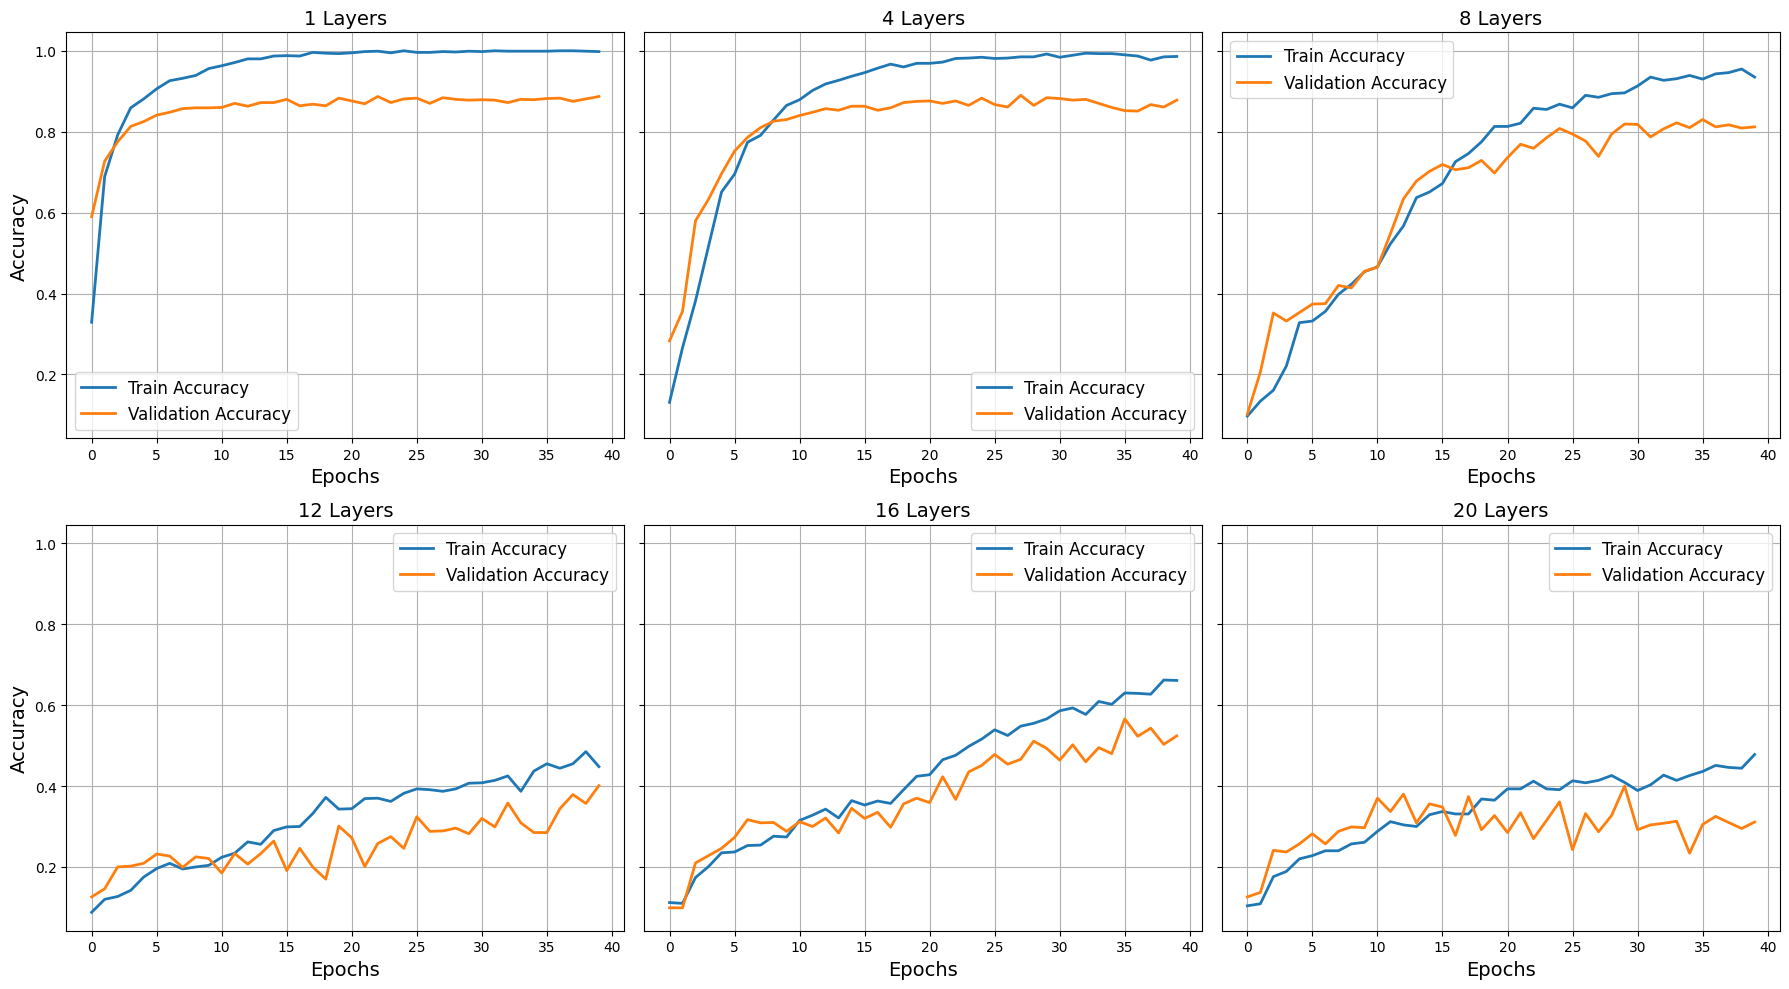

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

**Actividad**: El rendimiento mostrado en las curvas de aprendizaje actuales no es óptimo. Su tarea es ajustar los factores de $p$ en la tasa de dropout para mejorar el desempeño de nuestros modelos neuronales y reducir el sobreajuste.


**Preguntas para Reflexionar**


1. ¿Qué tan difícil es encontrar el parámetro adecuado? ¿Es un proceso fácil o requiere un análisis profundo?
¿De qué depende este factor?

2. Considere los factores que influyen en la elección del valor de regularización. ¿Cómo afecta la complejidad del modelo, la cantidad de datos, o la arquitectura general a la selección del factor de regularización?

**Resultado Esperado**
Encuentre el factor $p$ que mejor reduzca el sobreajuste y ofrezca el mejor desempeño general en el modelo. Este será el factor que minimice la diferencia entre las precisiones de entrenamiento y validación, logrando una mejor generalización a nuevos datos.

## 4.4 Parada temprana

La Parada Temprana (Early Stopping) es una técnica de regularización utilizada para evitar el sobreajuste en el entrenamiento de redes neuronales. Su objetivo es detener el entrenamiento cuando el rendimiento del modelo en un conjunto de validación comienza a deteriorarse, indicando que el modelo ha comenzado a sobreajustar el conjunto de entrenamiento.

Durante el entrenamiento, el modelo se evalúa en un conjunto de validación después de cada época. La Parada Temprana monitorea una métrica específica, como la pérdida de validación o la precisión de validación. El entrenamiento se detiene cuando la métrica de validación deja de mejorar durante un número definido de épocas consecutivas, conocido como el "paciencia".

### Parámetros

- **Monitoreo (`monitor`)**: La métrica a seguir para decidir cuándo detener el entrenamiento. Puede ser 'val_loss' para la pérdida de validación o 'val_accuracy' para la precisión de validación.
- **Paciencia (`patience`)**: Número de épocas que se permite esperar después de la última mejora en la métrica de validación antes de detener el entrenamiento.
- **Mejor modelo (`restore_best_weights`)**: Si es `True`, el modelo restaurará los pesos del mejor punto de validación encontrado durante el entrenamiento.


In [ ]:
# Importa la clase EarlyStopping desde el módulo tensorflow.keras.callbacks.
# EarlyStopping es un callback utilizado para interrumpir el entrenamiento de una red neuronal
# cuando una métrica de validación no mejora después de un número determinado de épocas.
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def addLayer(dense_input, n):
    """
    Añade capas densas (fully connected) a una red neuronal de manera recursiva.

    Args:
    dense_input (Tensor): La entrada a la capa densa, que puede ser la salida de una capa anterior.
    n (int): El número de capas densas a añadir. Si n >= 2, se añaden capas adicionales recursivamente.

    Returns:
    Tensor: La salida de la última capa densa añadida.

    La función funciona de la siguiente manera:
    - Si n es mayor o igual a 2, se crea una nueva capa densa con 100 neuronas y activación ReLU, y se aplica recursivamente para añadir más capas.
    - Cuando n es igual a 1, se crea la última capa densa con 100 neuronas y activación ReLU, y se retorna como la salida final.
    """
    if n >= 2:
        # Añade una capa densa con 100 neuronas y función de activación ReLU.
        resDense = Dense(100, activation='relu')(dense_input)
        # Llama a la función recursivamente para añadir más capas.
        return addLayer(resDense, n-1)
    # Añade la última capa densa cuando n es 1.
    resDenseOut = Dense(100, activation='relu')(dense_input)
    return resDenseOut

In [ ]:
def make_model(n):
    """
    Crea un modelo de red neuronal completamente conectada (MLP) con un número variable de capas densas ocultas.

    Args:
    n (int): El número de capas densas ocultas a añadir al modelo.

    Returns:
    keras.Model: Un modelo de Keras que incluye una capa de entrada, capas densas ocultas y una capa de salida.

    El modelo se construye de la siguiente manera:
    - Se limpia cualquier sesión anterior de Keras para evitar conflictos de estado.
    - Se define una capa de entrada con forma (28, 28) que representa imágenes en escala de grises de 28x28 píxeles.
    - La entrada se aplana utilizando una capa `Flatten` para convertir la imagen 2D en un vector 1D.
    - Se añade una primera capa densa con 100 neuronas y activación ReLU.
    - Se añaden capas densas ocultas adicionales utilizando la función `addLayer`, que toma el número `n` como argumento.
    - Finalmente, se añade una capa de salida con 10 neuronas y activación softmax para la clasificación de 10 dígitos.
    - El modelo se retorna con el nombre `modeloDenso{n}`, donde `{n}` es el número de capas ocultas.

    La función `addLayer` es utilizada para añadir el número deseado de capas densas ocultas, variando la complejidad del modelo según el valor de `n`.
    """
    keras.backend.clear_session()  # Limpia la sesión de Keras para evitar conflictos de estado
    inputs = Input(shape=[28, 28], name='InputLayer')  # Capa de entrada para imágenes de 28x28 píxeles
    flatten = Flatten(name='FlattenLayer')(inputs)  # Aplana la entrada para convertirla en un vector 1D
    firstLayer = Dense(100, activation='relu')(flatten)  # Primera capa densa con 100 neuronas y activación ReLU
    lastLayer = addLayer(firstLayer, n)  # Añade capas densas ocultas adicionales usando la función addLayer
    outputs = Dense(10, activation='softmax', name='OutputLayer')(lastLayer)  # Capa de salida para clasificación en 10 clases
    return keras.Model(inputs=inputs, outputs=outputs, name=f'modeloDenso{n}')  # Retorna el modelo con el nombre especificado

In [ ]:
#  Lista que define el número de capas ocultas a utilizar en los modelos de red neuronal.
number_layers = [1, 4, 8, 12, 16, 20]

# Diccionario para guardar resultados
learning_curves = {}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configura el diccionario para almacenar los resultados
learning_curves = {}

# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for number_layer in number_layers:
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model(number_layer)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Configura el callback de parada temprana
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitoriza la pérdida de validación para decidir cuándo detener el entrenamiento
        patience=5,          # Número de épocas sin mejora para detener el entrenamiento
        restore_best_weights=True  # Restaura los pesos del modelo en la mejor época
    )

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante un número máximo de épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0,
                        callbacks=[early_stopping])  # Añade el callback de parada temprana

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results


Model 1 layers done: acc_train 1.00, acc_val 0.87
Model 4 layers done: acc_train 1.00, acc_val 0.84
Model 8 layers done: acc_train 0.99, acc_val 0.83
Model 12 layers done: acc_train 0.97, acc_val 0.79
Model 16 layers done: acc_train 0.97, acc_val 0.72
Model 20 layers done: acc_train 0.84, acc_val 0.69


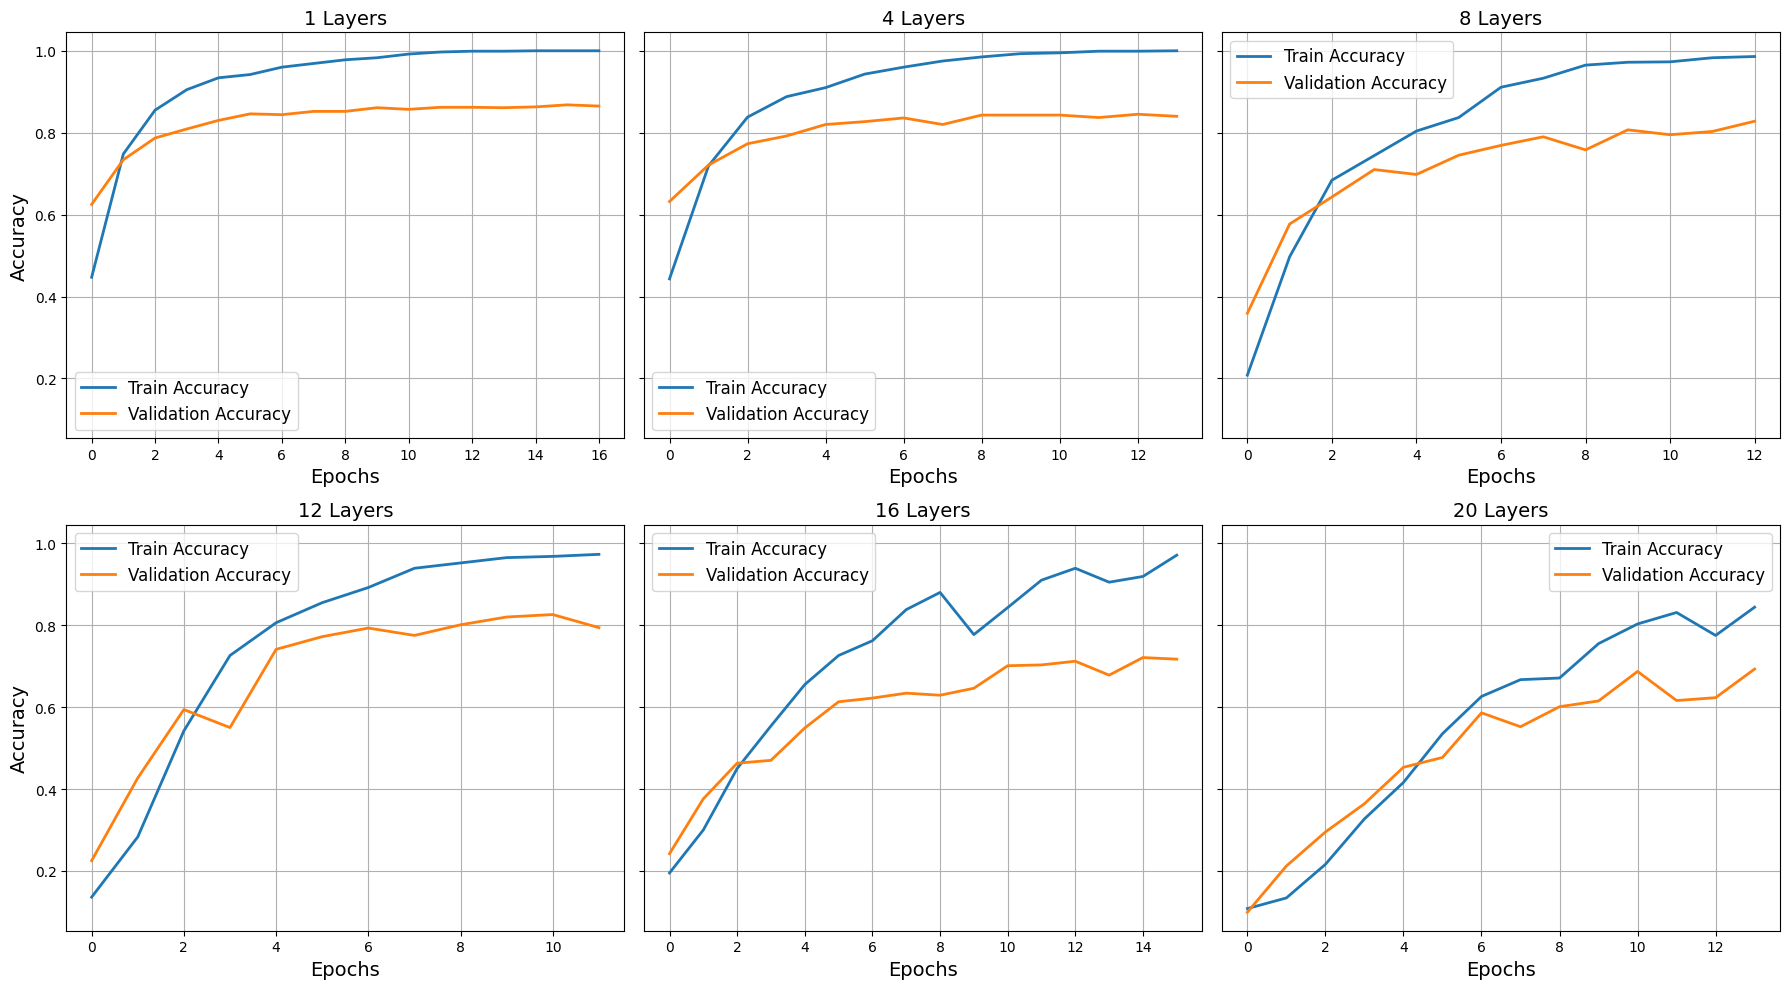

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

## 4.5 Regularización generalizada

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#  Lista que define el número de capas ocultas a utilizar en los modelos de red neuronal.
number_layers = [1, 4, 8, 12, 16, 20]

dropout_probabilities = [0.35, 0.3, 0.25, 0.2, 0.1, 0.1]

# Diccionario para guardar resultados
learning_curves = {}

In [ ]:
# Itera sobre cada número de capas ocultas en la lista `number_layers`.
for p, number_layer in zip(dropout_probabilities, number_layers):
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model_dropout(number_layer, p)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    # Configura el callback de parada temprana
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitoriza la pérdida de validación para decidir cuándo detener el entrenamiento
        patience=5,          # Número de épocas sin mejora para detener el entrenamiento
        restore_best_weights=True  # Restaura los pesos del modelo en la mejor época
    )

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante un número máximo de épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0,
                        callbacks=[early_stopping])  # Añade el callback de parada temprana

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

Model 1 layers done: acc_train 0.99, acc_val 0.87
Model 4 layers done: acc_train 0.97, acc_val 0.85
Model 8 layers done: acc_train 0.86, acc_val 0.78
Model 12 layers done: acc_train 0.36, acc_val 0.36
Model 16 layers done: acc_train 0.66, acc_val 0.60
Model 20 layers done: acc_train 0.46, acc_val 0.37


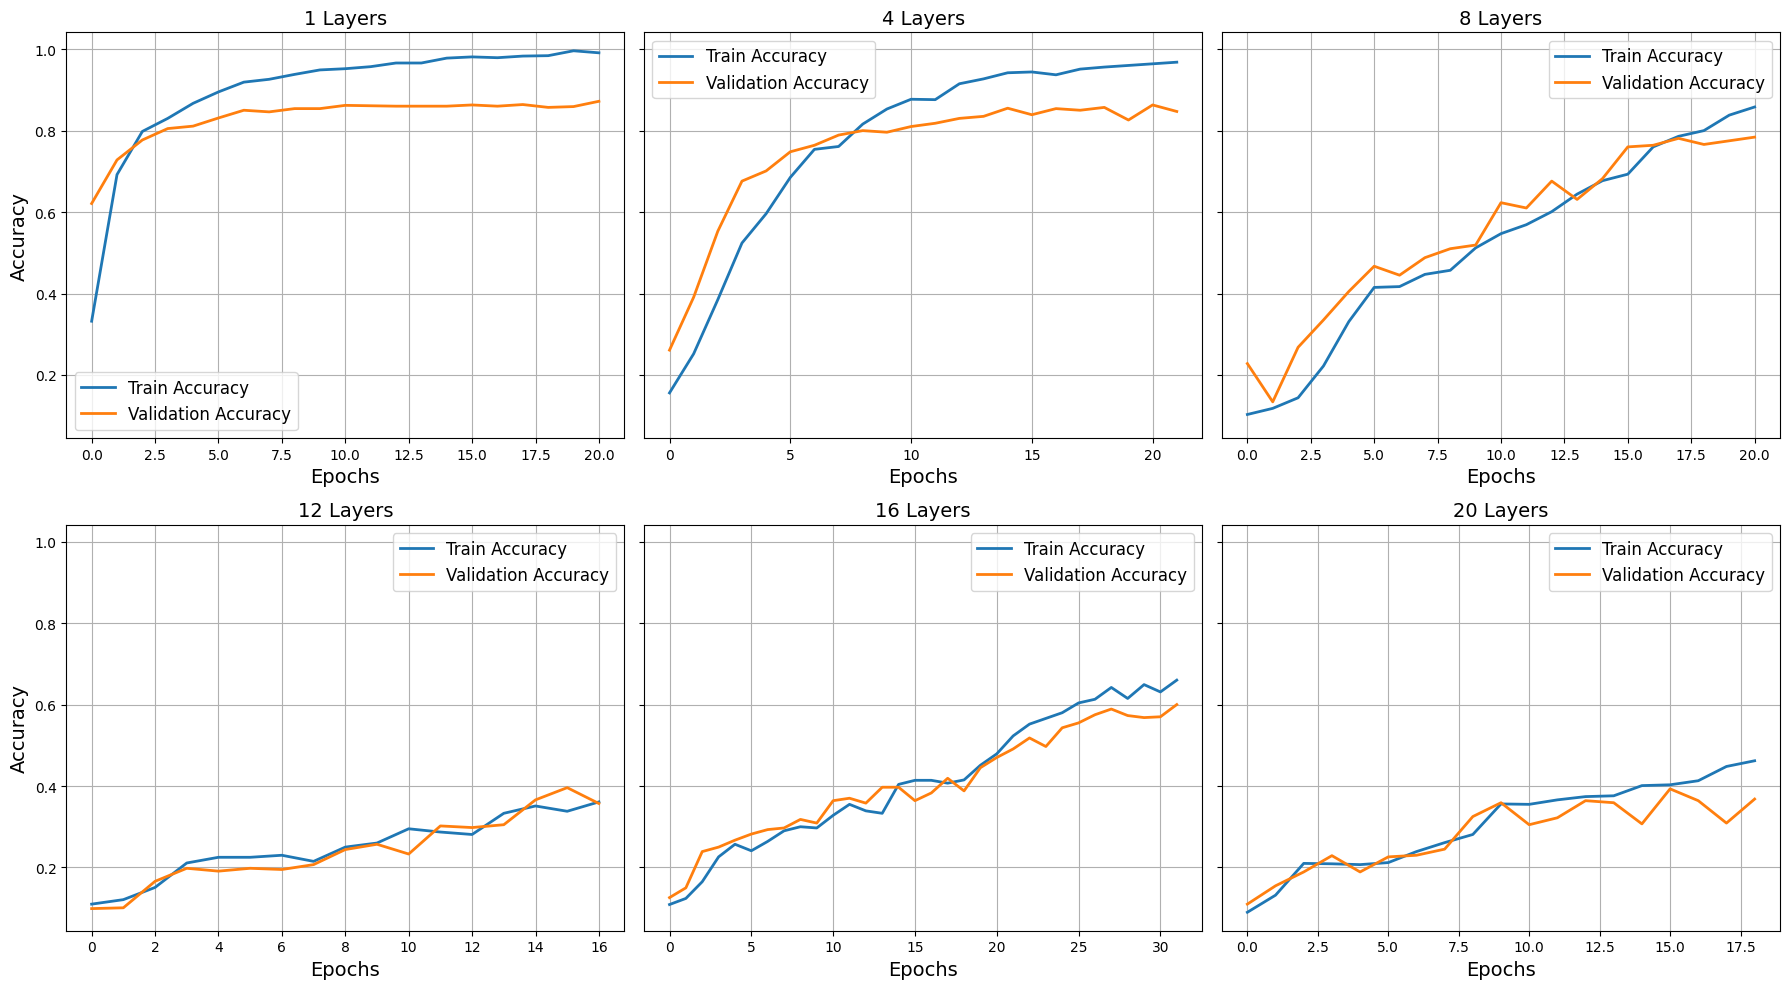

In [ ]:
# Crea una figura y una cuadrícula de subgráficas con 2 filas y 3 columnas.
# El tamaño total de la figura es de 18x10 pulgadas, y todas las subgráficas comparten el mismo eje y.
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Itera sobre los índices y los números de capas en el diccionario `learning_curves`.
for i, number_layer in enumerate(learning_curves):
    # Selecciona el eje correspondiente en la cuadrícula de subgráficas.
    ax = axes[i // 3, i % 3]

    # Traza la precisión de entrenamiento a lo largo de las épocas en el eje seleccionado.
    ax.plot(learning_curves[number_layer].history['accuracy'],
            label='Train Accuracy', lw=2)

    # Traza la precisión de validación a lo largo de las épocas en el mismo eje.
    ax.plot(learning_curves[number_layer].history['val_accuracy'],
            label='Validation Accuracy', lw=2)

    # Establece el título de la subgráfica con el número de capas.
    ax.set_title(f'{number_layer} Layers', fontsize=14)

    # Establece la etiqueta del eje x.
    ax.set_xlabel('Epochs', fontsize=14)

    # Solo establece la etiqueta del eje y en la primera columna de subgráficas.
    if i % 3 == 0:
        ax.set_ylabel('Accuracy', fontsize=14)

    # Añade una leyenda a la subgráfica con un tamaño de fuente de 12.
    ax.legend(fontsize=12)

    # Activa la cuadrícula para la subgráfica.
    ax.grid()

# Ajusta el diseño para que no haya superposiciones en las subgráficas.
plt.tight_layout()

# Muestra la figura con las subgráficas.
plt.show()

# 5. Validación con imágenes adversarias

En esta sección, exploraremos una técnica avanzada para evaluar la robustez de nuestros modelos, conocida como **validación con imágenes adversarias**. Esta metodología nos permitirá observar otra faceta del sobreajuste y cómo afecta el rendimiento de nuestros modelos en condiciones adversas.

El sobreajuste no solo se manifiesta cuando un modelo falla en generalizar en un conjunto de validación regular, sino también cuando es **particularmente vulnerable a pequeños cambios o perturbaciones** en los datos de entrada. Las imágenes adversarias son ejemplos específicamente diseñados para inducir errores en un modelo de aprendizaje automático, aprovechando las debilidades en su capacidad de generalización.

¿Qué Haremos en Esta Sección?

- **Generación de Imágenes Adversarias:** Utilizaremos el método *Fast Gradient Method (FGM)* para crear imágenes adversarias a partir de nuestro conjunto de prueba. Este método genera perturbaciones que, aunque pequeñas, son lo suficientemente significativas para confundir a nuestros modelos.
  
- **Evaluación de Modelos con Imágenes Adversarias:** Una vez generadas estas imágenes, evaluaremos el desempeño de nuestros modelos previamente entrenados para verificar cómo se ven afectados bajo este tipo de ataque. Esto nos permitirá medir la robustez del modelo y, de manera indirecta, observar los efectos del sobreajuste en escenarios adversos.


## 5.1 Generación imágenes adversarias

In [ ]:
def fsgm_attack(x, y, model):
    """
    Realiza un ataque adversarial utilizando el método Fast Gradient Sign Method (FGSM).

    Este ataque genera una perturbación adversarial a partir de la entrada original `x`
    para engañar al modelo. Lo hace calculando el gradiente de la función de pérdida
    respecto a la entrada y aplicando el signo del gradiente para determinar la dirección
    en la que se debe modificar la entrada. El resultado es una pequeña perturbación
    que, al sumarse a la entrada original, puede hacer que el modelo falle en su predicción.

    Parámetros:
    x (Tensor): Entrada original que se desea perturbar.
    y (Tensor): Etiqueta verdadera correspondiente a la entrada.
    model (tf.Model): Modelo de red neuronal que se va a atacar.

    Retorna:
    Tensor: Gradiente con signo que representa la dirección de la perturbación adversarial.
    """

    # Se utiliza un 'GradientTape' para seguir las operaciones y permitir la diferenciación automática
    with tf.GradientTape() as tape:
        # Se calcula la predicción del modelo para la entrada x
        prediction = model(x)
        # Se calcula la función de pérdida comparando la predicción con la etiqueta real y
        loss_function = keras.losses.categorical_crossentropy
        loss = loss_function(y, prediction)
    # Se calcula el gradiente de la función de pérdida respecto a la entrada x
    gradient = tape.gradient(loss, x)
    # Se obtiene el signo del gradiente, que indica la dirección en la que el input x debe ser modificado
    # Se retorna el gradiente con signo, que se utilizará para modificar la entrada original en el ataque FGSM
    return tf.sign(gradient)

In [ ]:
def scale_image(x):
    """
    Escala la imagen `x` para que sus valores estén dentro del rango [0, 1].

    La función aplica una transformación lineal a la imagen, reescalando los valores
    de los píxeles para que el mínimo valor en `x` se mapee a 0 y el máximo valor se mapee a 1.

    Fórmula usada: y = mx + b
    - m es la inversa del rango de `x` (diferencia entre el máximo y el mínimo valor de `x`).
    - b es el término de ajuste que garantiza que el valor mínimo se mapea a 0.

    Parámetro:
    x (ndarray): Arreglo numpy que representa la imagen a escalar.

    Retorna:
    ndarray: Imagen escalada con valores en el rango [0, 1].
    """
    # Calcula la pendiente m como la inversa del rango de los valores en x
    m = 1 / (np.max(x) - np.min(x))
    # Calcula el término de ajuste b para que el valor mínimo de x se mapee a 0
    b = -1 * m * np.min(x)
    # Escala la imagen aplicando la transformación lineal y = mx + b
    return m * x + b * np.ones(len(x))

In [ ]:
def graph_digits(X, y):
  fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

  ax = ax.flatten()
  for i in range(10):
      img = X[y == i][0].reshape(28, 28)
      ax[i].imshow(img, cmap='gist_yarg')

  ax[0].set_xticks([])
  ax[0].set_yticks([])

  plt.show()

Muestra de imágenes originales en el conjunto de validación


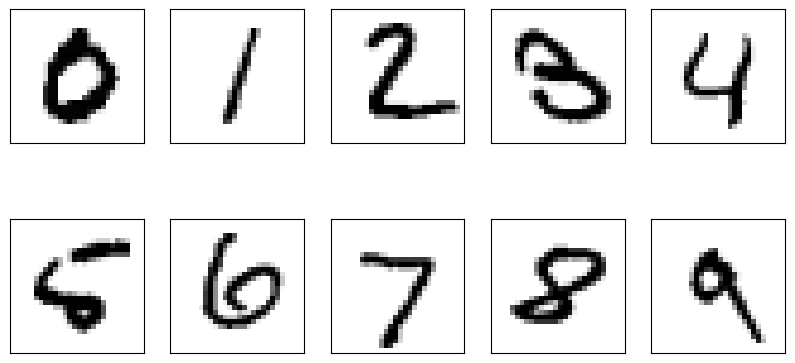

In [ ]:
print("Muestra de imágenes originales en el conjunto de validación")
graph_digits(X_test, y_test)

## 5.2 Validación de modelos con imágenes adversarias

In [ ]:
# Diccionario para guardar resultados
learning_curves = {}
# Diccionario para guardar modelos
models = {}

In [ ]:
for number_layer in [2, 3, 4]:
    # Crea un modelo neuronal con el número actual de capas ocultas.
    model = make_model(number_layer)

    # Compila el modelo con la función de pérdida 'categorical_crossentropy', el optimizador 'adam' y la métrica 'accuracy'.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrena el modelo usando el conjunto de datos de entrenamiento, durante 40 épocas, con un tamaño de batch de 64.
    # Usa el conjunto de datos de prueba para validación durante el entrenamiento.
    results = model.fit(X_train, y_train_onehot,
                        epochs=40,
                        batch_size=64,
                        validation_data=(X_test, y_test_onehot),
                        verbose=0)

    # Obtiene la precisión final en el conjunto de entrenamiento del historial de resultados.
    acc_train = results.history['accuracy'][-1]

    # Obtiene la precisión final en el conjunto de validación del historial de resultados.
    acc_val = results.history['val_accuracy'][-1]

    # Imprime la precisión final en el conjunto de entrenamiento y en el de validación para el modelo actual.
    print(f'Model {number_layer} layers done: acc_train {acc_train:0.2f}, acc_val {acc_val:0.2f}')

    # Almacena los resultados del entrenamiento en el diccionario `learning_curves` con el número de capas como clave.
    learning_curves[number_layer] = results

    # Guardar modelo entrenado
    models[number_layer] = model

Model 2 layers done: acc_train 1.00, acc_val 0.86
Model 3 layers done: acc_train 1.00, acc_val 0.85
Model 4 layers done: acc_train 1.00, acc_val 0.87


Imágenes perturbadas con rho=0.015


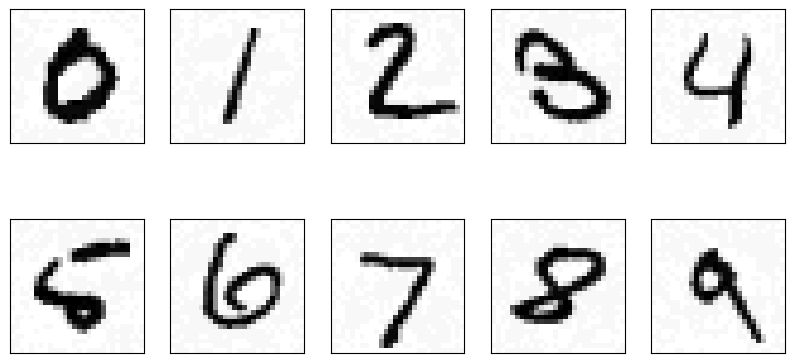

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.67
Imágenes perturbadas con rho=0.025


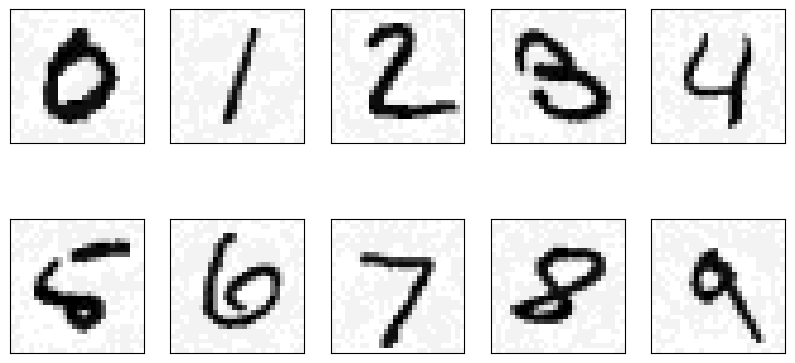

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.46
Imágenes perturbadas con rho=0.035


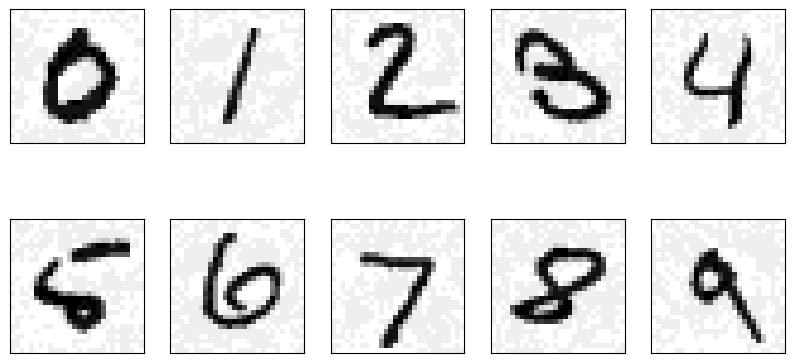

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.27
Imágenes perturbadas con rho=0.015


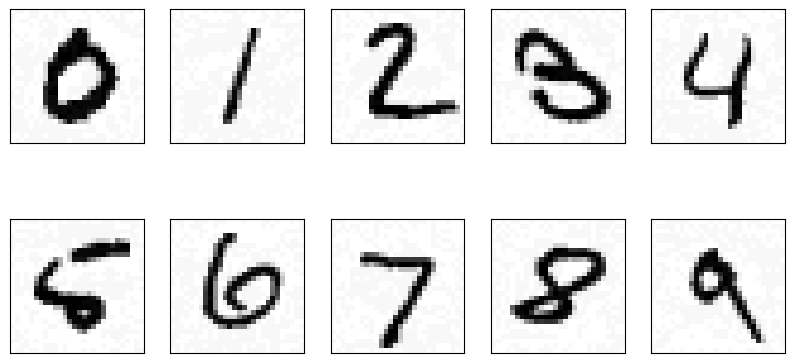

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.63
Imágenes perturbadas con rho=0.025


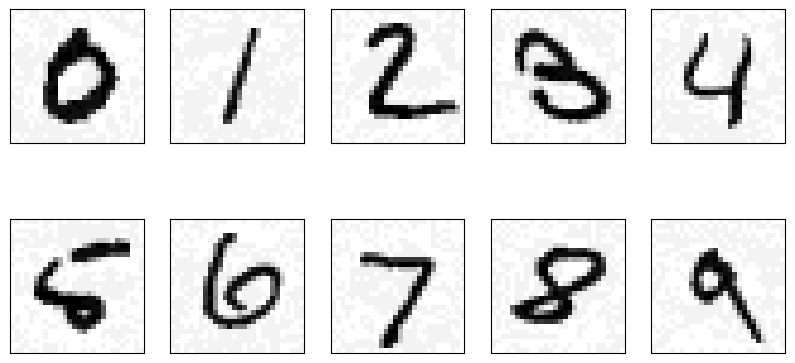

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluación del modelo: 0.43
Imágenes perturbadas con rho=0.035


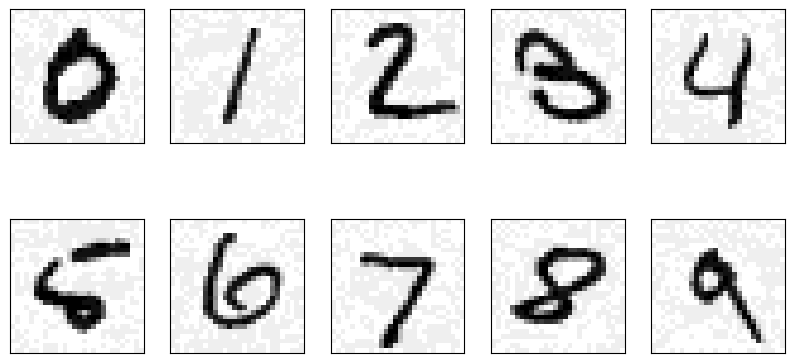

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.23
Imágenes perturbadas con rho=0.015


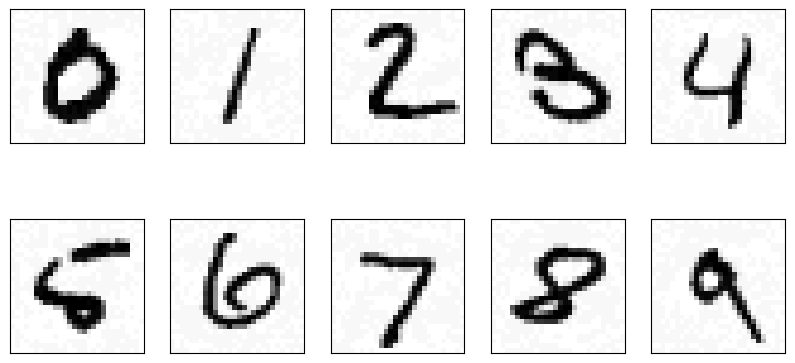

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.62
Imágenes perturbadas con rho=0.025


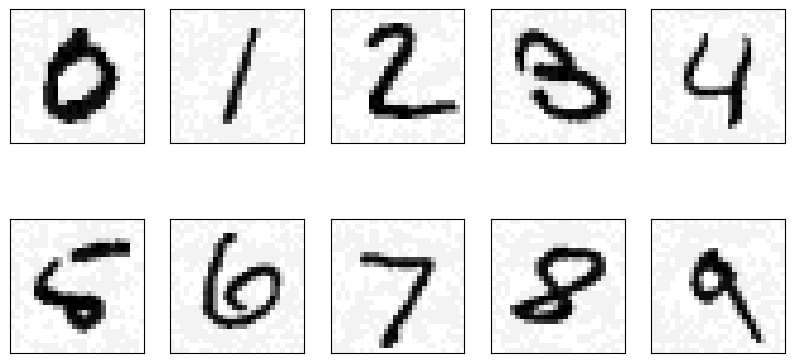

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluación del modelo: 0.37
Imágenes perturbadas con rho=0.035


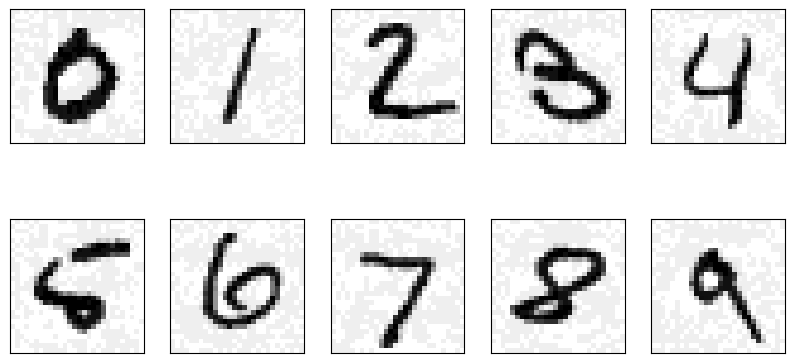

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluación del modelo: 0.19


In [ ]:
# Diccionario para almacenar la evaluación de los modelos
eval_models = {}

# Diferentes valores de rho que representan la magnitud de la perturbación adversarial
rhos = [0.015, 0.025, 0.035]

# Iteramos sobre diferentes modelos, cada uno con un número distinto de capas
for number_layer in [2, 3, 4]:

    model = models[number_layer]

    eval_models_by_rho = {}

    # Iteramos sobre cada valor de rho para evaluar la robustez del modelo
    for rho in rhos:
        # Inicializamos un arreglo para almacenar las imágenes perturbadas
        X_test_attack = np.zeros((1000, 28, 28))

        # Iteramos sobre el conjunto de prueba
        for i, (x_test, y_test_one) in enumerate(zip(X_test, y_test_onehot)):
            # Convertimos las imágenes y etiquetas de prueba en tensores

            x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
            x_tensor1 = tf.expand_dims(x_tensor1, axis=0)

            y_tensor1 = tf.convert_to_tensor(y_test_one, dtype='float32')
            y_tensor1 = tf.expand_dims(y_tensor1, axis=0)

            y_tensor = y_tensor1
            x_tensor = x_tensor1
            del x_tensor1, y_tensor1

            x = tf.Variable(x_tensor)
            y = tf.Variable(y_tensor)
            del x_tensor, y_tensor

            # Calculamos el gradiente adversarial usando el ataque FGSM
            signed_grad = fsgm_attack(x,y,model)

            # Convertimos el gradiente a un arreglo numpy y aplicamos la perturbación
            x_test_new = x_test + rho * signed_grad.numpy()

            # Escalamos la imagen perturbada y la almacenamos en el arreglo de ataque
            X_test_attack[i] = scale_image(x_test_new)

        print(f'Imágenes perturbadas con rho={rho}')
        graph_digits(X_test_attack, y_test)

        # Realizamos predicciones sobre las imágenes perturbadas
        y_pred = model.predict(X_test_attack)

        # Evaluamos la precisión del modelo y almacenamos los resultados
        eval_models_by_rho[rho] = accuracy_score(y_true=y_test, y_pred=np.argmax(y_pred, axis=-1))
        print(f'Evaluación del modelo: {eval_models_by_rho[rho]:0.2f}')
    # Guardamos la evaluación para el modelo actual con las diferentes perturbaciones
    eval_models[number_layer] = eval_models_by_rho

In [ ]:
for number_layer in [2, 3, 4]:
  for rho in rhos:
    print(f'Modelo {number_layer}, perturbación {rho}, acc {eval_models[number_layer][rho]:0.2f}')
  print('\n')

Modelo 2, perturbación 0.015, acc 0.67
Modelo 2, perturbación 0.025, acc 0.46
Modelo 2, perturbación 0.035, acc 0.27


Modelo 3, perturbación 0.015, acc 0.63
Modelo 3, perturbación 0.025, acc 0.43
Modelo 3, perturbación 0.035, acc 0.23


Modelo 4, perturbación 0.015, acc 0.62
Modelo 4, perturbación 0.025, acc 0.37
Modelo 4, perturbación 0.035, acc 0.19




## Preguntas de Reflexión

1. **¿Cómo afecta la complejidad del modelo a su robustez ante imágenes adversarias?**  Considera cómo los modelos más complejos, con un mayor número de parámetros, podrían comportarse frente a perturbaciones adversarias. ¿Por qué crees que los modelos más complejos pueden ser más vulnerables a estos ataques?

2. **¿Por qué los modelos que sobreajustan tienden a ser menos robustos?**  Reflexiona sobre la relación entre el sobreajuste y la falta de generalización, y cómo esto puede hacer que un modelo sea más susceptible a ataques adversarios.

3. **¿Crees que la regularización podría mejorar la robustez del modelo ante imágenes adversarias?**  Piensa en las técnicas de regularización que has aprendido (L1, L2, dropout) y cómo podrían influir en la capacidad de un modelo para resistir perturbaciones adversarias. ¿Podrían estas técnicas ayudar a reducir la vulnerabilidad a estos ataques?

5. **¿Qué implicaciones tiene la falta de robustez en aplicaciones del mundo real?**  Considera las consecuencias de tener un modelo que no es robusto en aplicaciones críticas, como la seguridad, la salud o la conducción autónoma. ¿Qué riesgos podrías enfrentar al desplegar un modelo que es vulnerable a ataques adversarios en estos contextos?

---------------